# Аналитика удовлетворенностью работой сотрудников компании "Работа с заботой"

***Описание проекта:*** HR-аналитикам компании "Работа с заботой" необходима помощь в оценке удовлетворенности компании с  целью минимизации оттока сотрудников и снижения рисков для компании. Результатом помощи ожидается модель МО, которая позволит добиться необходимых HR аналитикам целей.

***Цели проекта:*** в данном проекте необходимо добиться двух целей:
1) Создание модели МО для прогнозирования уровня удовлетворённости сотрудника на основе данных заказчика<br>
2) Создание модели МО для прогнозирования вероятности уволнения сотрудника

***Задачи проекта:***
- Загрузка и предварительный анализ предоставленных данных
- Предобработка данных
- Исследовательский анализ данных
- Создание пайплайнов и обучение моделей МО
- Анализ результатов и выбор лучшей модели МО<br>
P.S. Эти задачи необходимо будет произвести дважды в проекте для удовлетворения обеих целей проекта

***Требования проекта:***<br>
1) Модель по прогнозированию уровня удовлетворенности работой должна показать результат **не более 15** по метрике SMAPE<br>
2) Модель по прогнозированию вероятности увольнения сотрудника должна показать результат **не менее 0.91** по метрике ROC-AUC

<font size=5>**Загрузка необходимых библиотек проекта**</font>

<font size=4>Бибилиотеки для предобработки и анализа данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
from phik.report import plot_correlation_matrix
from phik import phik_matrix

<font size=4>Бибилиотеки для модели МО

In [2]:
# Пайплайны
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Предобработка
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

# Метрики
from sklearn.metrics import make_scorer, roc_auc_score

# Поиск лучшей модели
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, mutual_info_regression, f_regression

# Алгоритмы МО
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import shap

<font size=4>Константы

In [3]:
RANDOM_STATE = 94

## Модель МО по прогнозированию удовлетворенности работой сотрудника

### Загрузка и предварительный обзор данных

В данном блоке будет произведена загрузка предоставленных таблиц и их предварительный анализ. <span id='download_func'>Перед этим напишем функцию для записи данных

In [9]:
def read_file(path):
    # Делаем проверку на случай некорректного пути к файлу
    try:
        # Чтение файла
        df = pd.read_csv(path)
        print('Вывод пяти случайны строк фрейма для проверки корректности чтения файла')
        display(df.sample(5, random_state=RANDOM_STATE))
        # Выведем размер фрейма
        print(f'\nФрейм состоит из {df.shape[1]} признаков и {df.shape[0]} объектов\n')
        print('Вывод общих данных о фрейме')
        df.info()
        return df
    except:
        print('Ошибка в чтении файла. Проверьте адрес', path)
        return None

#### Загрузка тренировочной выборки (файл `train_job_satisfaction_rate.csv`)

In [10]:
satisfaction_train = read_file('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

Вывод пяти случайны строк фрейма для проверки корректности чтения файла


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3779,488518,sales,middle,medium,4,no,no,4,33600,0.46
3638,460067,sales,sinior,high,10,no,no,4,64800,0.63
3047,202770,purchasing,middle,low,6,no,no,4,28800,0.92
203,585996,sales,junior,high,1,no,no,4,31200,0.64
3078,354833,hr,junior,medium,2,no,yes,4,22800,0.55



Фрейм состоит из 10 признаков и 4000 объектов

Вывод общих данных о фрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


***Итог загрузки:***<br>
- Тренировочный фрейм содержит данные о 4000 сотрудниках, 10 признаков
- <span id='sat_tasks'>В признаках `dept` и `level` присутствуют пустоты (замена будет производиться в пайплане модели МО).<br>
- Стоит проверить данные на полные дубликаты, дубликаты `id` (все значения `id` должны быть уникальны), неявные дубликаты в признаках `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`.
- После проверки на уникальность признака `id`, стоит использовать его в качестве индекса

#### Загрузка тестовой выборки (файл `test_features.csv`)<br>
Учтем [недочет](#sat_error), выявленный на прошлом шаге и загрузим файл из полного адреса

In [11]:
satisfaction_test = read_file('https://code.s3.yandex.net/datasets/test_features.csv')

Вывод пяти случайны строк фрейма для проверки корректности чтения файла


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
870,529698,sales,junior,low,2,no,yes,2,14400
1293,399847,marketing,middle,medium,7,no,no,5,37200
1444,493723,technology,middle,low,5,yes,no,2,21600
1057,648995,sales,middle,low,5,no,no,4,19200
1135,592952,technology,middle,medium,2,no,no,5,45600



Фрейм состоит из 9 признаков и 2000 объектов

Вывод общих данных о фрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


***Итог загрузки:***<br>
- Тестовый фрейм содержит данные о 2000 сотрудниках, 9 признаков (10ый признак - целевой - выделен в отдельный файл)
- Необходимо провести [преобразования](#sat_tasks), аналогичные данным тренировочной выборке

#### Загрузка целевого признака тестовой выборки (файл `test_target_job_satisfaction_rate.csv`)

In [12]:
satisfaction_target = read_file('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

Вывод пяти случайны строк фрейма для проверки корректности чтения файла


,id,job_satisfaction_rate
870,280623,0.88
1293,779595,0.36
1444,992914,0.49
1057,520386,0.66
1135,612023,0.31



Фрейм состоит из 2 признаков и 2000 объектов

Вывод общих данных о фрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


***Итог загрузки:***<br>
- Фрейм с целевым признаком содержит данные о 2000 сотрудниках, 2 признака
- Необходимо проверить признак `id` на наличие дубликатов
- Стоит проверить, все ли `id` совпадают с `id` тестового фрейма
- После вышеуказанных проверок данный признак сделаем индексом

#### Промежуточный вывод шага

- В тренировочной и тестовой выборках присутствуют пустоты. Замена будет произведена в пайплайнах
- Тренировочную и тестовую выборки необходимо проверить на наличие дубликатов, в том числе неявных
- Признак `id` стоит сделать индексом

### Предобработка данных

Как было выявлено на прошлом шаге, задачами на этом шаге будет поиск и устранение дубликатов, а также замена индекса.<br>
Воспользуемся кастомной функцией, которая выведет следующие данные фрейма:
- Количество полных дубликатов
- Наличие дубликатов в признаке `id`
- Уникальные значения признаков типа `object`

Это позволит разово изучить фрейм на наличие дубликатов любого вида

In [13]:
def look_for_duplicates(frame):
    # Выводим число полных дубликатов
    total_dupl = frame.duplicated().sum()
    print(f'В данном фрейме присутствуют {total_dupl} полных дубликатов')
    # Вывод дубликатов, если такие есть
    if total_dupl:
        display(frame[frame.duplicated()])
    
    # Выводим кол-во дубликатов признака id
    id_dupl = frame['id'].duplicated().sum()
    print(f'В данном фрейме присутствуют {id_dupl} повторяющихся id')
    # Вывод дубликатов, если такие есть
    if id_dupl:
        display(frame[frame['id'].duplicated()])
    
    # Вывод уникальных значений признаков типа 'object'
    for column in frame.columns:
        # Пропускаем ненужные типы
        if frame[column].dtype != 'object':
            continue
        # Получаем уникальные значения, пустоты убираем фильтрацией
        uniques = list( # Фильтрация значений Nan
                        filter(
                            # Функция фильтрации, проверяющая тип значения
                            lambda item: type(item) is str,
                            # аргумент функции - уникальные значения признака
                            frame[column].unique()
                        )
                  )
        print(f'В признаке "{column}" данного фрейма присутствует {len(uniques)} уникальных значений:', ", ".join(uniques))

#### Тренировочная выборка
Применим созданную функцию к тренировочной выборке и проанализируем результаты

In [14]:
look_for_duplicates(satisfaction_train)

В данном фрейме присутствуют 0 полных дубликатов
В данном фрейме присутствуют 0 повторяющихся id
В признаке "dept" данного фрейма присутствует 5 уникальных значений: sales, hr, technology, purchasing, marketing
В признаке "level" данного фрейма присутствует 3 уникальных значений: junior, middle, sinior
В признаке "workload" данного фрейма присутствует 3 уникальных значений: medium, high, low
В признаке "last_year_promo" данного фрейма присутствует 2 уникальных значений: no, yes
В признаке "last_year_violations" данного фрейма присутствует 2 уникальных значений: no, yes


В данном фрейме не обнаружено явных или неявных дубликатов.<br>
Можно сделать следующие выводы для будущей предобработки данных для модели МО:
- Признаки `level`, `workload` следует закодировать с помощью `OrdinalEncoder`, так как значения этих признаков составляют градацию
- К признакам `dept`, `last_year_promo` и `last_year_violations` следует применить `OneHotEncoder` кодировщик, так как значения признака представляют один из равноценных вариантов

Используем признак `id` в качестве индекса

In [15]:
satisfaction_train.set_index('id', inplace=True)
satisfaction_train.name = 'Тренировочная выборка для прогнозирования уровня удовлетворенности сотрудрников'
# Проверка
satisfaction_train.index

Index([155278, 653870, 184592, 171431, 693419, 405448, 857135, 400657, 198846,
       149797,
       ...
       430350, 895642, 854006, 424345, 855240, 457950, 957499, 533318, 706868,
       338347],
      dtype='int64', name='id', length=4000)

Преобразования фрейма завершены

#### Тестовая выборка
Проведем аналогичные шаги

In [16]:
look_for_duplicates(satisfaction_test)

В данном фрейме присутствуют 0 полных дубликатов
В данном фрейме присутствуют 0 повторяющихся id
В признаке "dept" данного фрейма присутствует 6 уникальных значений: marketing, hr, sales, purchasing, technology,  
В признаке "level" данного фрейма присутствует 3 уникальных значений: junior, middle, sinior
В признаке "workload" данного фрейма присутствует 4 уникальных значений: medium, low, high,  
В признаке "last_year_promo" данного фрейма присутствует 2 уникальных значений: no, yes
В признаке "last_year_violations" данного фрейма присутствует 2 уникальных значений: no, yes


Явных и неявных дубликатов не обнаружено<br>
В данном фрейме обнаружено две аномалии - в признаках `dept` и `workload` присутствуют значения " ".<br>
Выводы по данному фрейму:
- Фрейм содержит значения категориальных признаков аналогичные тренировочному фрейму (нет новых значений)
- <span id='advices_first'></span>При построении модели МО нужно будет учесть этот момент, изменив стандартный параметр `handle_unknown` в кодировщиках категориальных признаков
- Признаки `level`, workload следует закодировать с помощью `OrdinalEncoder`, так как значения этих признаков составляют градацию
- К признаку `dept`, `last_year_promo` и `last_year_violations` следует применить `OneHotEncoder` кодировщик, так как значения признака представляют один из равноценных вариантов

Проведем замену индекса

In [17]:
satisfaction_test.set_index('id', inplace=True)
# Проверка
satisfaction_test.index

Index([485046, 686555, 467458, 418655, 789145, 429973, 850699, 500791, 767867,
       937235,
       ...
       609235, 630684, 760964, 380255, 497976, 393147, 109582, 305653, 160233,
       771859],
      dtype='int64', name='id', length=2000)

Преобразование фрейма завершено

#### Целевой признак тестовой выборки
В данном фрейме необходимо лишь проверить уникальность признака `id`, поэтому применять функцию невыгодно

In [18]:
id_dupl = satisfaction_target['id'].duplicated().sum()
print(f'В данном фрейме присутствуют {id_dupl} повторяющихся id')
# Вывод дубликатов, если такие есть
if id_dupl:
    display(satisfaction_target[satisfaction_target['id'].duplicated()])

В данном фрейме присутствуют 0 повторяющихся id


Дубликатов нет, преобразуем индекс 

In [19]:
satisfaction_target.set_index('id', inplace=True)
# Проверка
satisfaction_target.index

Index([130604, 825977, 418490, 555320, 826430, 817219, 269033, 962356, 649052,
       532834,
       ...
       361996, 111415, 393147, 126400, 367507, 405257, 370925, 857722, 303402,
       648995],
      dtype='int64', name='id', length=2000)

Преобразований больше не требуется

#### Промежуточный вывод шага
Были проанализированы три предоставленных фрейма. Проводился поиск дубликатов (явных/неявных) во всех фреймах. Были сделаны следующие выводы:<br>
***Тестовая выборка***
- Признаки `level`, `workload` следует закодировать с помощью `OrdinalEncoder`, так как значения этих признаков составляют градацию
- Признак `supervisor_evaluation` также содержит градацию. Несмотря на то, что это количественный признак, его не стоит подвергать масштабированию, а стоит передать модели без изменения
- К признакам `dept`, `last_year_promo` и `last_year_violations` следует применить `OneHotEncoder` кодировщик, так как значения признака представляют один из равноценных вариантов<br>

***Тестовая выборка***
- Фрейм содержит значения категориальных признаков аналогичные тренировочному фрейму (нет новых значений)
- При построении модели МО нужно будет учесть этот момент, изменив стандартный параметр `handle_unknown` в кодировщиках категориальных признаков<br>

По ***целевому признаку тестовой выборки*** выводов нет.

Во всех трех фреймах за индекс был принят признак `id`

### Исследовательский анализ данных
На данном шаге будет произведен анализ фрейма ***тренировочной выборки***. Это позволит оценить и подготовить данные к построению модели МО. ***Тестовую выборку*** и ***Целевой признак тестовой*** выборки анализировать нет необходимости, так как эти данные нужны лишь для тестирования корректности полученной модели.

#### Анализ распределения значений

Составим функцию для автоматизированного построения графиков по распределению признаков. Данную функцию также будем переиспользовать во второй части проекта, поэтому на вход функции мы будем передавать фрейм в качестве параметра

In [20]:
# Функция для вывода графиков
def make_plot(frame):
    # Оптимальное число корзин по правилу Квиксола
    bins = int(log(frame.shape[0], 2)) + 1
    # Проходим циклом по колонкам фрейма
    for column in frame.columns:
        # Для нечисловых значений строим столбчатый график
        if ~hasattr(frame, 'name'):
            frame.name = 'Заданный фрейм'
        if frame[column].dtype == 'object':
            plt.figure(figsize=(9, 5))
            plt.ylabel('Количество сотрудников')
            plt.xlabel(f'Значения признака {column}')
            (
                frame[column].value_counts()
                             .sort_values(ascending=False)
                             .plot(
                                 kind='bar',
                                 title=f'Распределение значений признака "{column}" в "{frame.name}"'
                             )
            )
        # Для числовых значений - гистограмму распределения и ящик с усами
        else:
            # Делим на две зоны
            fig, axs = plt.subplots(1, 2, figsize=(16, 7))
            # Гистограмма
            axs[0].hist(frame[column],
                        bins=bins,
                        label=f'Значения признака "{column}"')
            # Вертикальная линия медианного значения
            axs[0].axvline(frame[column].median(),
                           color='red',
                           linestyle='--',
                           label=f'Медиана значений признака "{column}"')
            # Вертикальная линия среднего значения
            axs[0].axvline(frame[column].mean(),
                           color='red',
                           linestyle='-',
                           label=f'Среднее значение признака "{column}"')
            # Описание графика
            axs[0].legend(loc='best', fontsize='x-small')
            axs[0].set_ylabel('Количество сотрудников')
            axs[0].set_xlabel('Распределение значений')
            axs[0].set_title(f'Гистограмма распределения значений признака {column}', fontsize=8)
            
            # Ящик с усами
            axs[1].boxplot(frame[column],
                           vert=False)
            # Описание графика
            axs[1].set_xlabel('Распределение значений') 
            axs[1].set_title(f'Диаграмма размаха значений признака {column}', fontsize=8)
            
        # Выводим график
        plt.show()

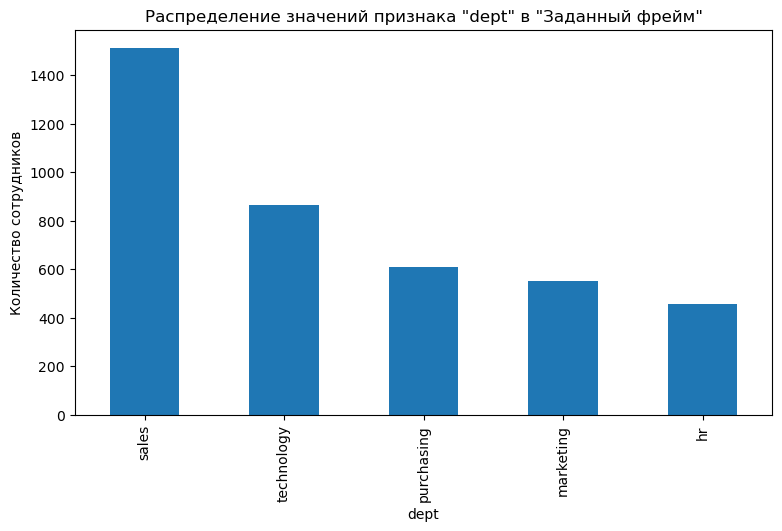

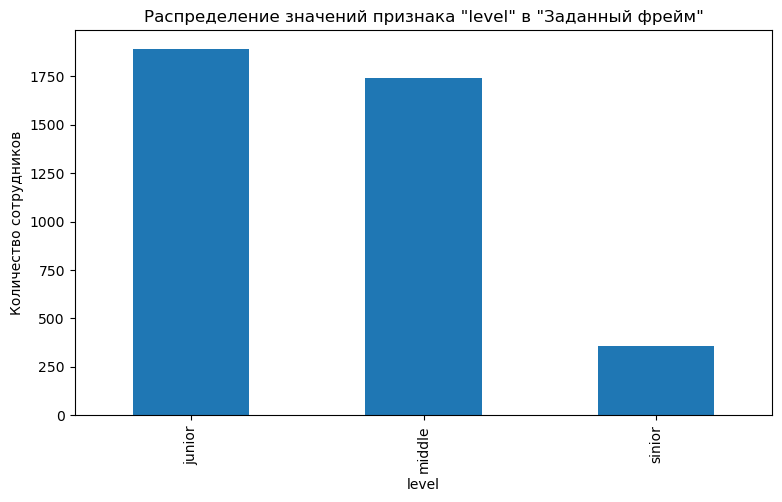

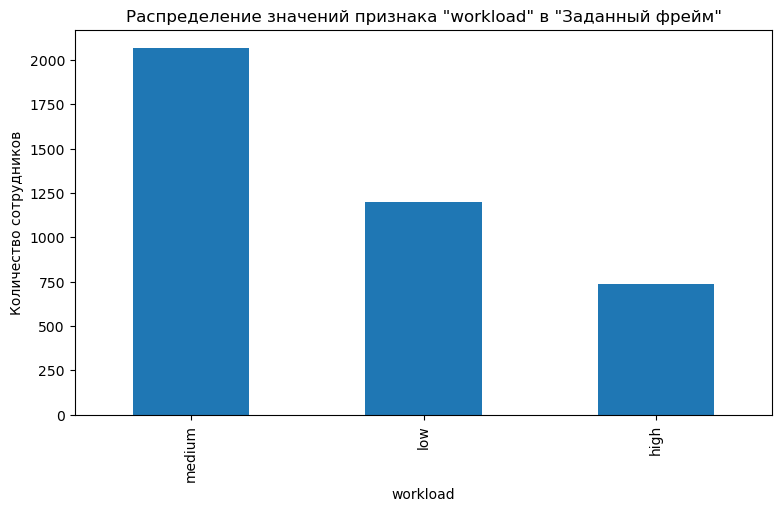

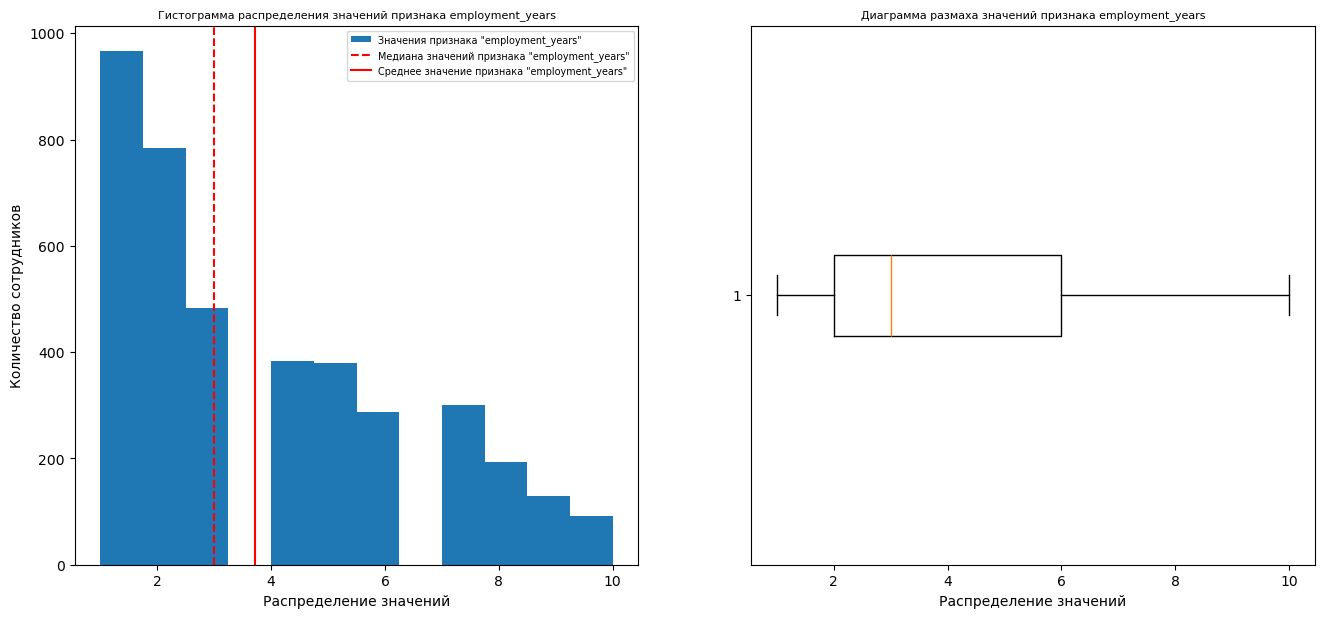

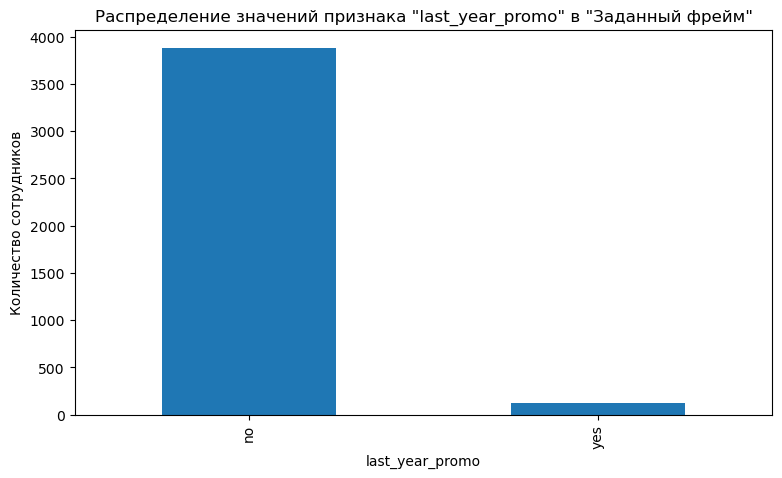

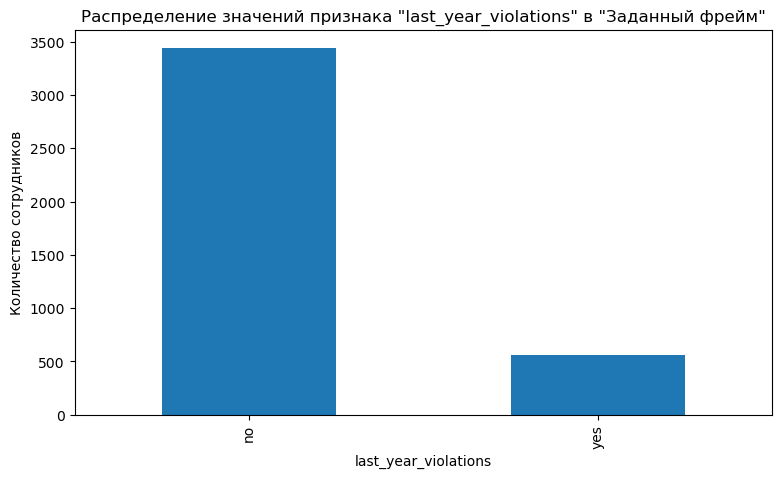

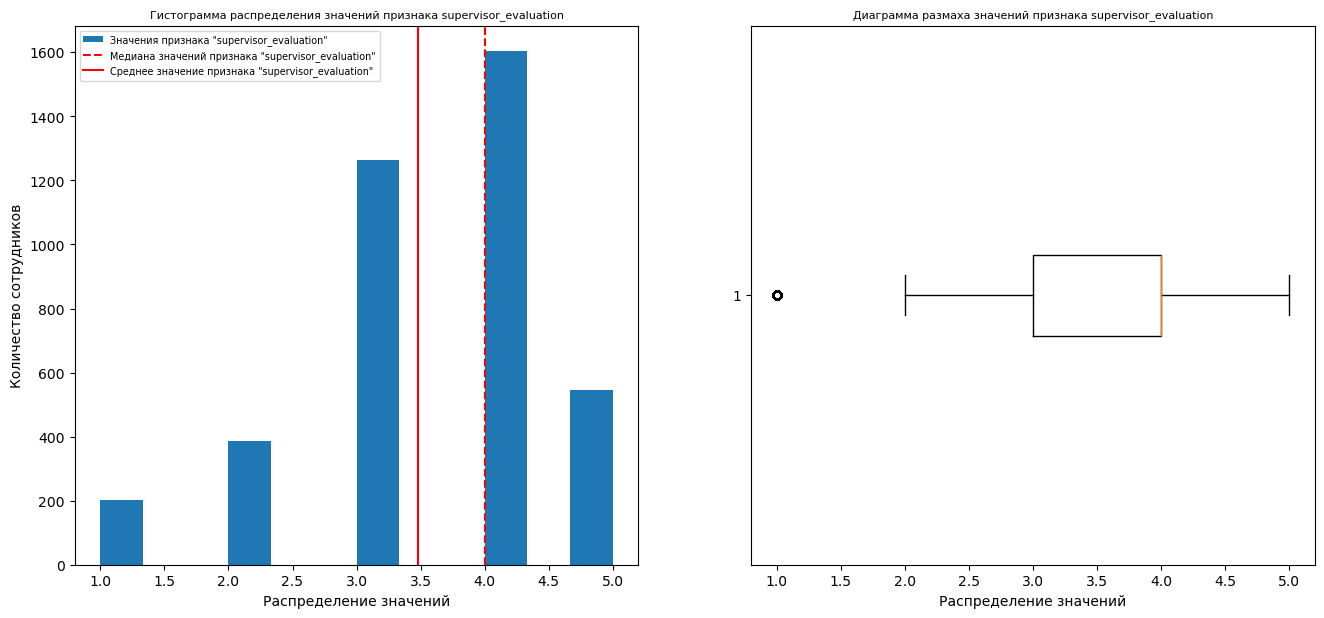

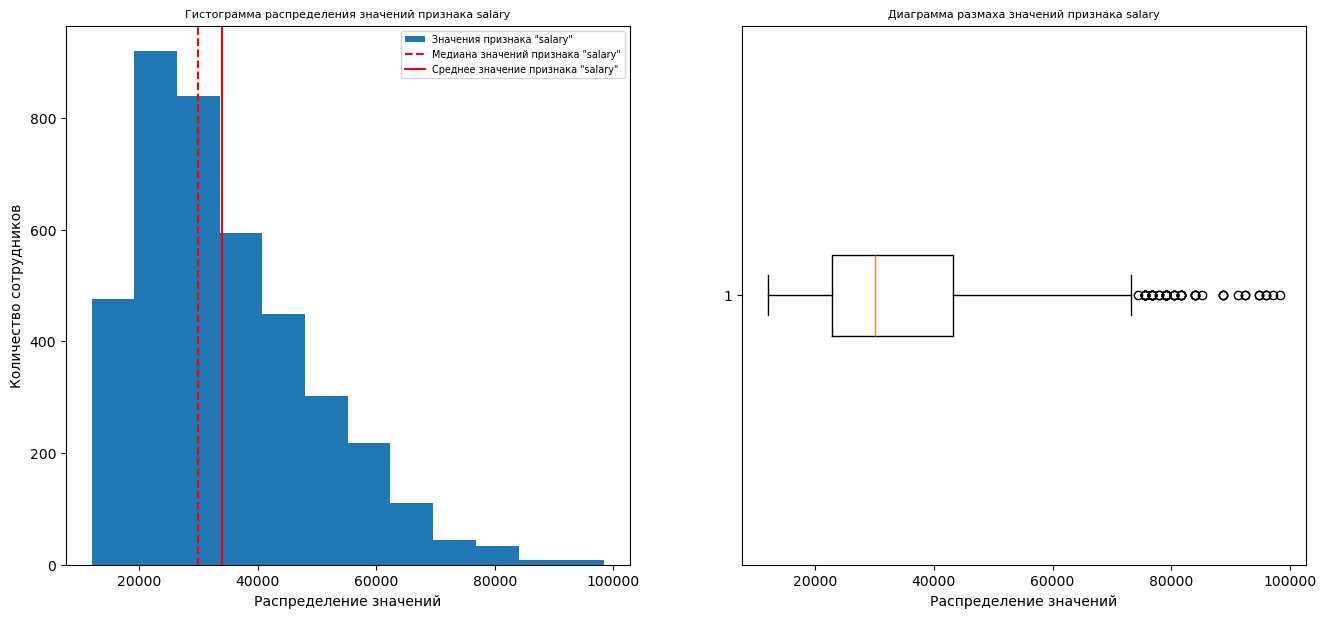

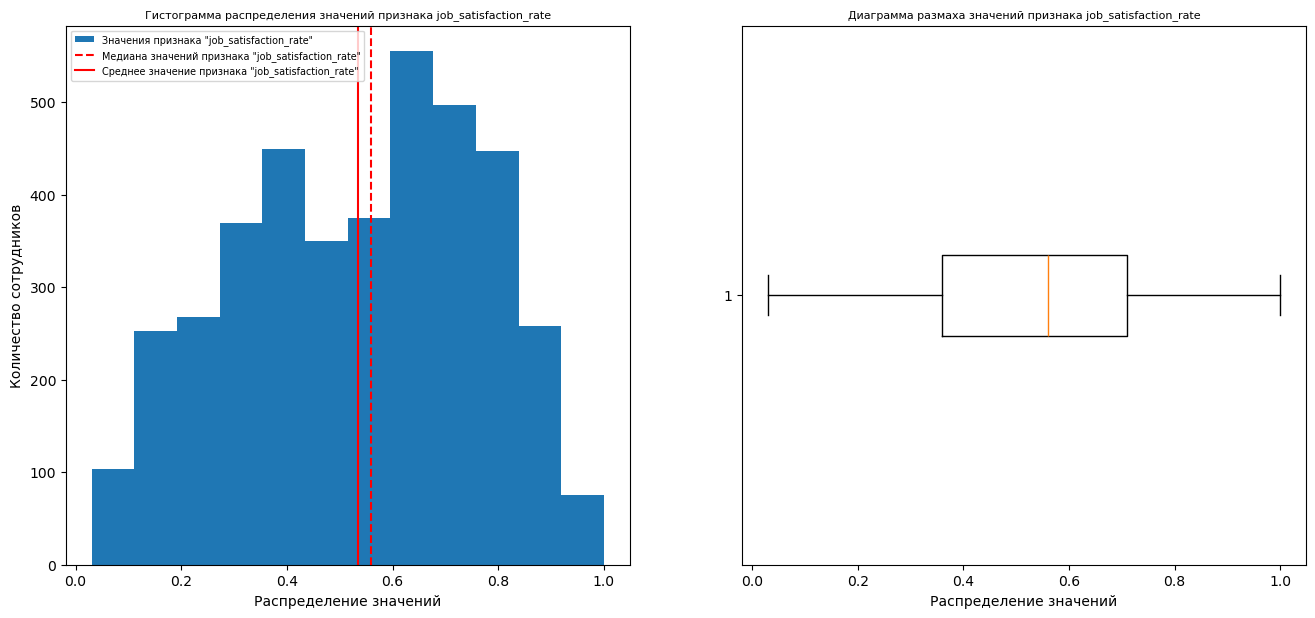

In [21]:
make_plot(satisfaction_train)

<span id='del_over_first'>На двух диаграммах размаха видны выбросы:
- **Признак `supervisor_evaluation`** - выброс связан с низкопрофессиональным сотрудником
- **Признак `salary`** - выброс связан с топ менеджментом или другими высоко-оплачиваемыми позициями

От данных выбросов стоит избавиться.

In [22]:
satisfaction_train_filtered = satisfaction_train.query('salary < 70000 and supervisor_evaluation > 1')

<span id='analysis_plots_first'>Согласно данным графикам можно заключить следующее о среднестатистическом сотруднике компании:
- Работает в департаменте sales
- Занимает junior/middle позицию
- Имеет средний уровень загруженности
- Работает в компании 3 года
- Не был повышен в прошлом году
- Не имел нарушений трудового договора в прошлом году
- Руководитель оценивает работу данного сотрудника на 4 из 5
- Зарабатывает около 30 тысяч
- Оценивает удовлетворенность работой на ~ 55%

#### Корреляционный анализ данных

<span id='corr_matrix_first'>Построим матрицу корреляции для определения наиболее коррелируемых с целевым признаков. Воспользуемся библиотекой phik

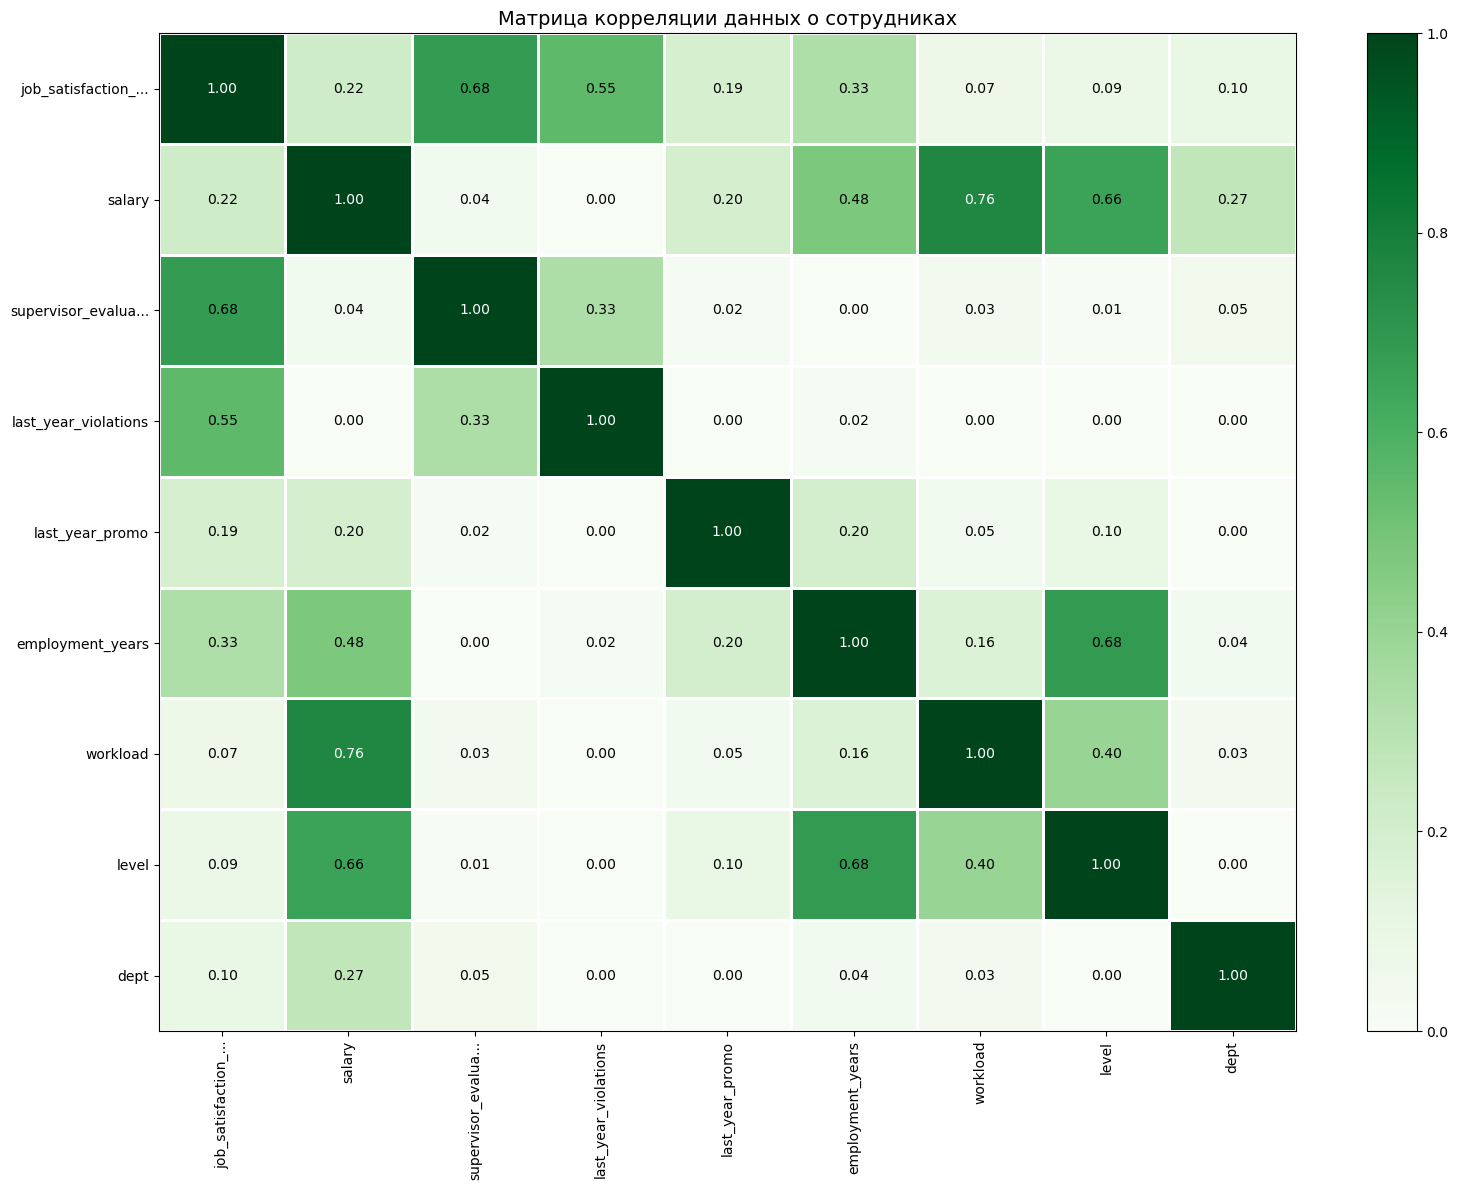

In [23]:
# Создаем матрицу корреляции
phik_overview = phik_matrix(satisfaction_train_filtered,
                            interval_cols=['salary', 'job_satisfaction_rate'])

# Визуализируем матрицу
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Greens',
    title='Матрица корреляции данных о сотрудниках',
    figsize=(16, 12)
) 

<span id='got_right'>По представленному графику можно заключить, что целевой признак больше всего коррелирует с признаками:
- `supervisor_evaluation` - сотрудникам нравится работы, если их чаще хвалит руководитель
- `last_year_violations` - тут скорее обратная взаимосвязь: чем больше сотрудник доволен работой, тем меньше вероятность нарушения трудового договора

<span id='multi-corr'>Также обнаружена мультиколлинеарность между признаками:
- `Salary` и `Workload` - более трудолюбивые сотрудники поощряются больше
- `Employment_years` и `Level` - Со стажем сотрудник продвигается в карьерной лестинце (занимает более высокие позиции)
- `Salary` и `Level` - сотрудники на более высоких позициях зарабатвают больше
- `Salary` и `Employment_years` - сотрудники, дольше работающие в компании оплачиваются выше для их удержания

#### Промежуточный вывод шага

В данном шаге был проведен исследовательский анализ данных:<br>
***Анализ распределения значений:***<br>
Были построены столбчатые графики для категориальных признаков, а также гистограммы распределения и диаграммы размаха - для количественных признаков. [Промежуточные выводы](#analysis_plots_first) представил в соответствующем разделе. По итогу анализа были [исключены значения-выбросы](#del_over_first) в признаках **supervisor_evaluation** и **salary**. 

***Корреляционный анализ:***<br>
Была построена [матрица корреляции](#corr_matrix_first) для определения наиболее коррелируемых признаков и поиска возможной мультиколлиниарности входнх признаков.

### Подготовка данных

На данном шаге будет создан пайплайн предобработки данных для модели МО. Учтем [замечания](#advices_first) ранее и выявленные на прошлом шаге взаимосвязи. Начнем с разделения признаков на четыре списка для соответствующих кодировщиков:

In [24]:
# Список категориальных признаков для OneHotEncoder
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']

# Список категориальных признаков для OrdinalEncoder
ord_cols = ['workload', 'level']

# Список количественных признаков, которые не нужно масштабировать
stand_cols = ['salary', 'employment_years']

Признак `supervisor_evaluation` масштабировать не стоит, так как данный признак по сути является градацией

#### Пайплайн для обрработки категориальных признаков

Создадим пайплайн для обработки пропусков в категориальных признаках и их кодировании

In [25]:
# для OrdinalEncoder
ord_pipe = Pipeline(
   [
       (   # Заполнение пустых входных значений
           'imputer_before',
           SimpleImputer(missing_values=np.nan,
                         strategy='most_frequent')
       ),
       (   # Кодирование данных
           'ord',
           OrdinalEncoder(
                categories='auto', 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
           )
       ),
       (   # Заполнение пустых значений после кодирования
           'imputer_after', 
            SimpleImputer(missing_values=np.nan,
                          strategy='most_frequent')
       )
   ] 
)

# для OneHotEncoder
ohe_pipe = Pipeline(
    [
        (   # Заполнение пропусков
            'imputer',
            SimpleImputer(missing_values=np.nan,
                          strategy='most_frequent')            
        ),
        (   # Кодирование данных
            'ohe',
            OneHotEncoder(
                categories='auto',
                handle_unknown='ignore',
                sparse_output=False,
                drop='first'
            )
        )
    ]
)

#### Итоговый пайплайн предобработки данных

Теперь создадим общий пайплайн для предобработки данных

In [26]:
data_preprocessor = ColumnTransformer(
    [
        (
            'ohe',
            ohe_pipe,
            ohe_cols
        ),
        (
            'ord', 
            ord_pipe, 
            ord_cols
        ),
        (
            'quan',
            MinMaxScaler(),
            stand_cols
        )
    ], 
    remainder='passthrough'
)

#### Промежуточный вывод шага

Был создан пайплайн для предобработки данных. <span id='preproc_model_first'>При выборе лучшей модели в качестве параметров в данном пайплайне будут опробованы разные масштабирующие алгоритмы для поиска лучшего сочетания алгоритма МО и алгоритма масштабирования

### Обучение моделей

На данном шаге будет проведен поиск лучшей модели МО и ее гиперпараметров с помощью случайной кросс валидации. Лучшая модель будет протестирована на тестовой выборке.

В качестве метрики оценки будет использована кастомная метрика `SMAPE` (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). <span id='first_requirements'>**Для лучшей модели данный критерий не должен превышать 15.**

Начнем с создания данной метрики:

#### Создание метрики SMAPE

<span id='custom_metrics'>Воспользуемся формулой, предоставленной в задании

In [27]:
def smape_scoring(y_true, y_pred):
    # Количество наблюдений
    n = y_true.size
    
    y_pred = pd.Series(y_pred,
                       index=y_true.index)
    
    # Модуль разности факт. и пред. значений
    diff_module = (y_true - y_pred).abs()
    
    # Среднее арифм модулей факт. и пред. значений
    half_of_modules_sum = (y_true.abs() + y_pred.abs()) / 2
    
    # Итоговая метрика
    return 100 / n * (diff_module / half_of_modules_sum).sum()

Теперь создадим объект кастомной метрики. Установим значение **False** параметра `greater_is_better`, так как нам необходимо получить наименьшее значение метрики

In [28]:
smape_scorer = make_scorer(smape_scoring,
                           greater_is_better=False)

В данном методе важно, чтобы индексы тестовых и предсказанных значений совпадали, поэтому стоит удостовериться, что в целевом признаке и тестовых данных индексы совпадают. Объединим данные в один фрейм, проверим на полное объединение (нет ли пустых значений после объединений)

In [29]:
# Объединение фрейма
satisfaction_test_full = satisfaction_test.join(satisfaction_target)

# Проверка на корректность объединения
if ~satisfaction_test_full['job_satisfaction_rate'].isna().sum():
    print('Объединение успешно. Пустот нет')
else:
    print('Ошибка при объединении. Проверь индексы фреймов на совпадение')

Объединение успешно. Пустот нет


Теперь мы можем применить метрику для определения лучшей модели

#### Создание полного пайплайна

Соберем общий пайплайн для прогнозирования результатов

In [30]:
pipe_final= Pipeline(
    [
        (   # Предобработка данных
            'preprocessor',
            data_preprocessor
        ),
        (   # Отбор признаков
            'skb',
            SelectKBest(f_regression, k=2)
        ),
        (   # Алгоритм прогнозирования
            'model',
            LinearRegression()
        )
    ]
)

Итоговый пайплайн готов. Теперь стоит применить кросс-валидацию для поиска лучшего алгаритма прогнозирования (перебирая алгоритмы и их гиперпараметры) и [алгоритмы стандартизации](#preproc_model_first)

#### Поиск и анализ лучшей модели

Применим кросс валидацию на случайных наборах параметров (`RandomizedSearchCV`) к списку алгоритмов и их гиперпараметров для поиска лучшей модели. Начнем с алгоритмов стандартизации:

In [31]:
preprocessor__quan = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler()
]

Затем зададим распределение для отбора признаков

In [32]:
data_preprocessor.fit_transform(satisfaction_train_filtered.drop('job_satisfaction_rate', axis=1))
skb__k = range(2, len(data_preprocessor.get_feature_names_out()))

Теперь зададим алгоритмы и гиперпараметры для модели

In [33]:
model_params = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(5, 16),
        'model__min_samples_split': range(2, 11),
        'model__min_samples_leaf': range(1, 11),
        'skb__k': skb__k,
        'preprocessor__quan': preprocessor__quan
    },
    {
        'model': [LinearRegression()],
        'skb__k': skb__k,
        'preprocessor__quan': preprocessor__quan        
    }
]

Проведем поиск лучшей модели с помощью `RandomizedSearchCV`. В качестве метрики будем использовать [кастомную метрику](#custom_metrics)

In [34]:
search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=model_params, 
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    cv=10,
    n_jobs=-1
).fit(
    satisfaction_train_filtered.drop('job_satisfaction_rate', axis=1),
    satisfaction_train_filtered['job_satisfaction_rate']
)

Выведем значение метрики лучшей модели и ее гиперпараметры

In [40]:
print('Метрика SMAPE для лучшей модели:\n', -search.best_score_)
print('\nЛучшая модель и её параметры:\n', search.best_estimator_) 

Метрика SMAPE для лучшей модели:
 14.734298986929588

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                          

Итак по результатам кросс валидации лучшей моделью была выявлена модель `DecisionTreeRegressor` c максимальной глубиной 14, минимальным числом листов - 7 и числом объектов для деления - 7. При этом для модели выжны следующие признаки

In [41]:
# Выбираем лучшую модель
best_pipeline = search.best_estimator_

# Получаем наименования признаков после их преобразовния
coltrans = best_pipeline['preprocessor'].get_feature_names_out()

# Получаем наименования признаков после их отбора
skb_features = best_pipeline['skb'].get_feature_names_out(coltrans)
print(skb_features)

['ohe__dept_marketing' 'ohe__dept_purchasing' 'ohe__dept_technology'
 'ohe__last_year_promo_yes' 'ohe__last_year_violations_yes'
 'ord__workload' 'ord__level' 'quan__salary' 'quan__employment_years'
 'remainder__supervisor_evaluation']


Проверим качество модели на тестовой выборке

In [42]:
print('SMAPE метрика на тестовой выборке составляет:', 
      smape_scoring(satisfaction_test_full['job_satisfaction_rate'],
                    best_pipeline.predict(satisfaction_test_full.drop('job_satisfaction_rate', axis=1)))
)

SMAPE метрика на тестовой выборке составляет: 14.681199046157133


c:\Users\Public\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Таким образом, модель удовлетворяет [требованиям задачи](#first_requirements). Построим интерпретацию модели с помощью бибилиотеки `shap`

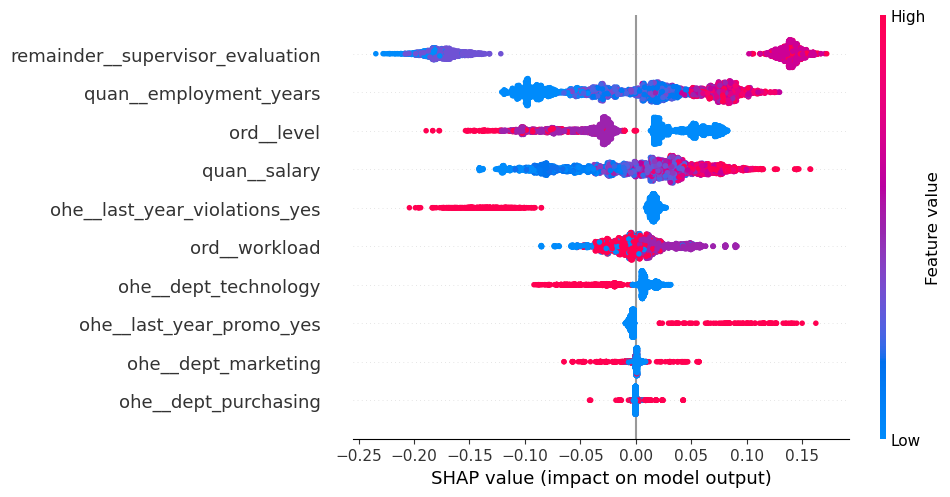

In [44]:
X_train_ = pd.DataFrame(
    best_pipeline['preprocessor'].transform(satisfaction_train_filtered.drop('job_satisfaction_rate', axis=1)),
    columns=coltrans
)[skb_features]

explainer = shap.TreeExplainer(best_pipeline['model'], X_train_)
shap_values = explainer(X_train_)

shap.plots.beeswarm(shap_values)

Выведем закодированные категории после `OrdinalEncoder`

In [45]:
best_pipeline['preprocessor'].transformers_[1][1][1].categories_

[array(['high', 'low', 'medium'], dtype=object),
 array(['junior', 'middle', 'sinior'], dtype=object)]

#### Промежуточный итог шага

Как и было [предсказано](#got_right) при корреляционном анализе, на уровень удовлетворенности влияет больше всего оценка работы руководителем (хорошо видно на графике, что высокая оценка руководителя повышает удовлетворенность работой и наоборот).
Также удовлетворенность работой повышают такие признаки как:
- **Продолжительность работы в компании** - "старые" сотрудники более довольны работой
- **Низшая позиция** - сотрудники на низких позициях имеют меньше ответственности, меньше погружены в "кухню" компании, а значит получают меньше стресса
- **Более высокая зарплата** - высокая зарплата позволяет больше тратить на "высшие" потребности, что позволяет сотруднику меньше стрессовать на работе
- **Отсутствие нарушений трудового договора в прошлом году** - обратная связь с удовлетворенностью работой (чем выше сотрудник удовлетворен работой, тем меньше вероятность, что он нарушит договор)
- **Работа не в департаменте technology** - возможно, самый застресованный департамент компании
- **Повышение в прошлом году** - повышение связано зачастую с повышением заработной платы, а ее влияние описано раннее

### Вывод первой задачи

Итак по результатам кросс валидации лучшей моделью была выявлена модель `DecisionTreeRegressor` c максимальной глубиной 14, минимальным числом листов - 7 и числом объектов для деления - 7. Масштабирующим алгоритмом при этом выбран `MinMaxScaler()`.

На тестовой выборке модель показала значение 14.681 по метрике `SMAPE`, что удовлетворяет требованию задачи.

На уровень удовлетворенности влияет больше всего оценка работы руководителем (хорошо видно на графике, что высокая оценка руководителя повышает удовлетворенность работой и наоборот).
Также удовлетворенность работой повышают такие признаки как:
- Продолжительность работы в компании
- Низшая позиция
- Более высокая зарплата
- Отсутствие нарушений трудового договора в прошлом году
- Работа не в департаменте technology
- Повышение в прошлом году

## Модель МО по прогнозированию вероятности увольнения сотрудника

### Загрузка и предварительный обзор данных

На данном шаге будет произведена загрузка данных из файлов. Воспользуемся функцией, что создали в [первой задаче](#download_func)

#### Загрузка тренировочной выборки (файл `train_quit.csv`)

In [47]:
quit_train = read_file('https://code.s3.yandex.net/datasets/train_quit.csv')

Вывод пяти случайны строк фрейма для проверки корректности чтения файла


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3779,900419,sales,junior,low,1,no,no,3,14400,yes
3638,425894,hr,middle,medium,7,no,no,3,34800,no
3047,835699,marketing,junior,low,3,no,no,4,16800,no
203,813659,marketing,junior,medium,2,no,no,4,31200,no
3078,670337,purchasing,junior,low,2,no,no,4,13200,yes



Фрейм состоит из 10 признаков и 4000 объектов

Вывод общих данных о фрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB



Входные признаки соответствуют тем, что использовались в первой задаче. Данный фрейм содержит 4000 строк, 10 признаков. Следует проверить на дубликаты. Также при создании модели МО следует закодировать целевой признак

#### Загрузка тестовой выборки (файл `test_features.csv`)

In [48]:
quit_test = read_file('https://code.s3.yandex.net/datasets/test_features.csv')

Вывод пяти случайны строк фрейма для проверки корректности чтения файла


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
870,529698,sales,junior,low,2,no,yes,2,14400
1293,399847,marketing,middle,medium,7,no,no,5,37200
1444,493723,technology,middle,low,5,yes,no,2,21600
1057,648995,sales,middle,low,5,no,no,4,19200
1135,592952,technology,middle,medium,2,no,no,5,45600



Фрейм состоит из 9 признаков и 2000 объектов

Вывод общих данных о фрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Тестовый фрейм также аналогичен тому, что был в первом задании. Видны пропуски в признаках `dept` и `level`. Эти пропуски будут учтены в пайплайне предобработки данных.

Стоит проверить фрейм на дубликаты

#### Загрузка целевого признака тестовой выборки (файл `test_target_quit.csv`)

In [49]:
quit_target = read_file('https://code.s3.yandex.net/datasets/test_target_quit.csv')

Вывод пяти случайны строк фрейма для проверки корректности чтения файла


,id,quit
870,980194,no
1293,771859,no
1444,763530,yes
1057,991523,no
1135,804959,no



Фрейм состоит из 2 признаков и 2000 объектов

Вывод общих данных о фрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Фрейм также аналогичен (по размерам) тому, что был в первом задании. Пустот нет, стоит проверить дубликаты в фрейме

#### Промежуточный вывод шага

- В тренировочной и тестовой выборках присутствуют пустоты. Замена будет произведена в пайплайнах
- Тренировочную и тестовую выборки необходимо проверить на наличие дубликатов, в том числе неявных
- Признак `id` стоит сделать индексом

### Предобработка данных

Как было выявлено на прошлом шаге, задачами на этом шаге будет поиск и устранение дубликатов, а также замена индекса.<br>
Воспользуемся кастомной функцией, которая выведет следующие данные фрейма:
- Количество полных дубликатов
- Наличие дубликатов в признаке `id`
- Уникальные значения признаков типа `object`

Это позволит разово изучить фрейм на наличие дубликатов любого вида. Применим функцию, созданную в первом задании

#### Тренировочная выборка

In [50]:
look_for_duplicates(quit_train)

В данном фрейме присутствуют 0 полных дубликатов
В данном фрейме присутствуют 0 повторяющихся id
В признаке "dept" данного фрейма присутствует 5 уникальных значений: sales, purchasing, marketing, technology, hr
В признаке "level" данного фрейма присутствует 3 уникальных значений: middle, junior, sinior
В признаке "workload" данного фрейма присутствует 3 уникальных значений: high, medium, low
В признаке "last_year_promo" данного фрейма присутствует 2 уникальных значений: no, yes
В признаке "last_year_violations" данного фрейма присутствует 2 уникальных значений: no, yes
В признаке "quit" данного фрейма присутствует 2 уникальных значений: no, yes


В данном фрейме не обнаружено явных или неявных дубликатов.<br>
Можно сделать следующие выводы для будущей предобработки данных для модели МО:
- Признаки `level`, `workload` следует закодировать с помощью `OrdinalEncoder`, так как значения этих признаков составляют градацию
- К признакам `dept`, `last_year_promo` и `last_year_violations` следует применить `OneHotEncoder` кодировщик, так как значения признака представляют один из равноценных вариантов

Используем признак `id` в качестве индекса

In [51]:
quit_train.set_index('id', inplace=True)
quit_train.name = 'Тренировочная выборка для прогнозирования вероятности увольнения сотрудрников'
# Проверка
quit_train.index

Index([723290, 814010, 155091, 257132, 910140, 699916, 417070, 165489, 996399,
       613206,
       ...
       632886, 778735, 106936, 387733, 775320, 588809, 672059, 536432, 692133,
       853842],
      dtype='int64', name='id', length=4000)

Преобразования фрейма завершены

#### Тестовая выборка

In [52]:
look_for_duplicates(quit_test)

В данном фрейме присутствуют 0 полных дубликатов
В данном фрейме присутствуют 0 повторяющихся id
В признаке "dept" данного фрейма присутствует 6 уникальных значений: marketing, hr, sales, purchasing, technology,  
В признаке "level" данного фрейма присутствует 3 уникальных значений: junior, middle, sinior
В признаке "workload" данного фрейма присутствует 4 уникальных значений: medium, low, high,  
В признаке "last_year_promo" данного фрейма присутствует 2 уникальных значений: no, yes
В признаке "last_year_violations" данного фрейма присутствует 2 уникальных значений: no, yes


Явных и неявных дубликатов не обнаружено<br>
В данном фрейме обнаружено две аномалии - в признаках `dept` и `workload` присутствуют значения " ".<br>
Выводы по данному фрейму:
- Фрейм содержит значения категориальных признаков аналогичные тренировочному фрейму (нет новых значений)
- При построении модели МО нужно будет учесть этот момент, изменив стандартный параметр `handle_unknown` в кодировщиках категориальных признаков
- Признаки `level`, `workload` следует закодировать с помощью `OrdinalEncoder`, так как значения этих признаков составляют градацию
- К признакам `dept`, `last_year_promo` и `last_year_violations` следует применить `OneHotEncoder` кодировщик, так как значения признака представляют один из равноценных вариантов

Проведем замену индекса

In [53]:
quit_test.set_index('id', inplace=True)
# Проверка
quit_test.index

Index([485046, 686555, 467458, 418655, 789145, 429973, 850699, 500791, 767867,
       937235,
       ...
       609235, 630684, 760964, 380255, 497976, 393147, 109582, 305653, 160233,
       771859],
      dtype='int64', name='id', length=2000)

Преобразования фрейма завершены

#### Целевой признак тестовой выборки

В данном фрейме необходимо лишь проверить уникальность признака `id`, поэтому применять функцию невыгодно

In [54]:
id_dupl = quit_target['id'].duplicated().sum()
print(f'В данном фрейме присутствуют {id_dupl} повторяющихся id')
# Вывод дубликатов, если такие есть
if id_dupl:
    display(quit_target[quit_target['id'].duplicated()])

В данном фрейме присутствуют 0 повторяющихся id


Сделаем `id` индексом

In [55]:
quit_target.set_index('id', inplace=True)

Преобразований больше не требуется

#### Промежуточный вывод шага
Были проанализированы три предоставленных фрейма. Проводился поиск дубликатов (явных/неявных) во всех фреймах. Были сделаны следующие выводы:<br>
***Тестовая выборка***
- Признаки `level`, `workload` следует закодировать с помощью `OrdinalEncoder`, так как значения этих признаков составляют градацию
- Признак `supervisor_evaluation` также содержит градацию. Несмотря на то, что это количественный признак, его не стоит подвергать масштабированию, а стоит передать модели без изменения
- К признакам `dept`, `last_year_promo` и `last_year_violations` следует применить `OneHotEncoder` кодировщик, так как значения признака представляют один из равноценных вариантов<br>

***Тестовая выборка***
- Фрейм содержит значения категориальных признаков аналогичные тренировочному фрейму (нет новых значений)
- При построении модели МО нужно будет учесть этот момент, изменив стандартный параметр `handle_unknown` в кодировщиках категориальных признаков<br>

По ***целевому признаку тестовой выборки*** выводов нет.

Во всех трех фреймах за индекс был принят признак `id`

### Исследовательский анализ данных
На данном шаге будет произведен анализ фрейма ***тренировочной выборки***. Это позволит оценить и подготовить данные к построению модели МО. ***Тестовую выборку*** и ***Целевой признак тестовой*** выборки анализировать нет необходимости, так как эти данные нужны лишь для тестирования корректности полученной модели.

#### Анализ распределения значений

Применим созданную в первом задании функцию для анализа распределения значений

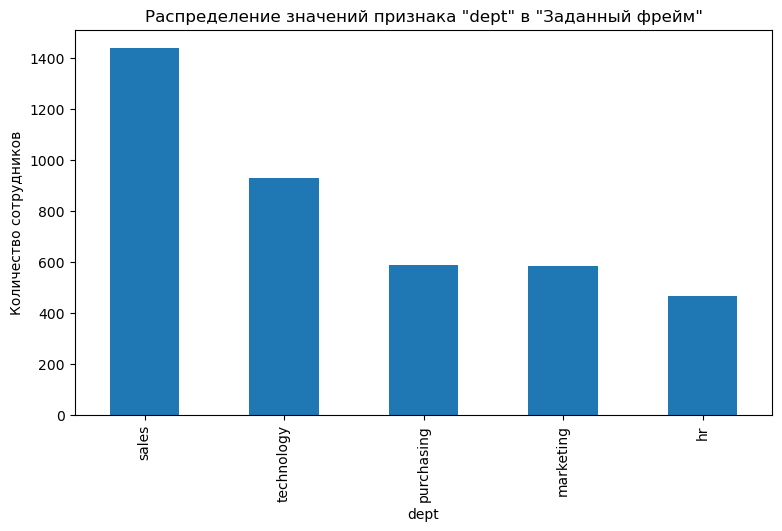

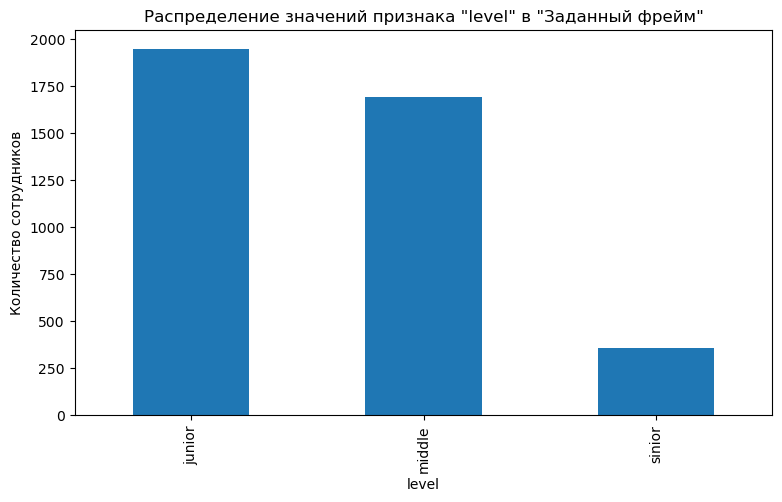

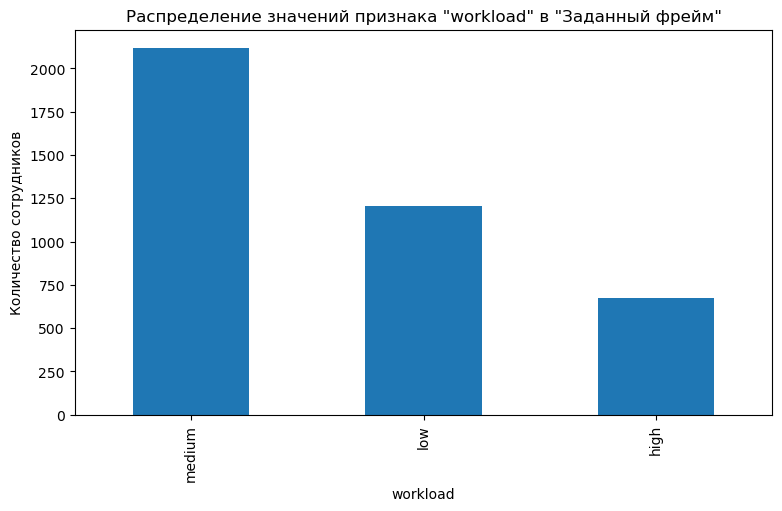

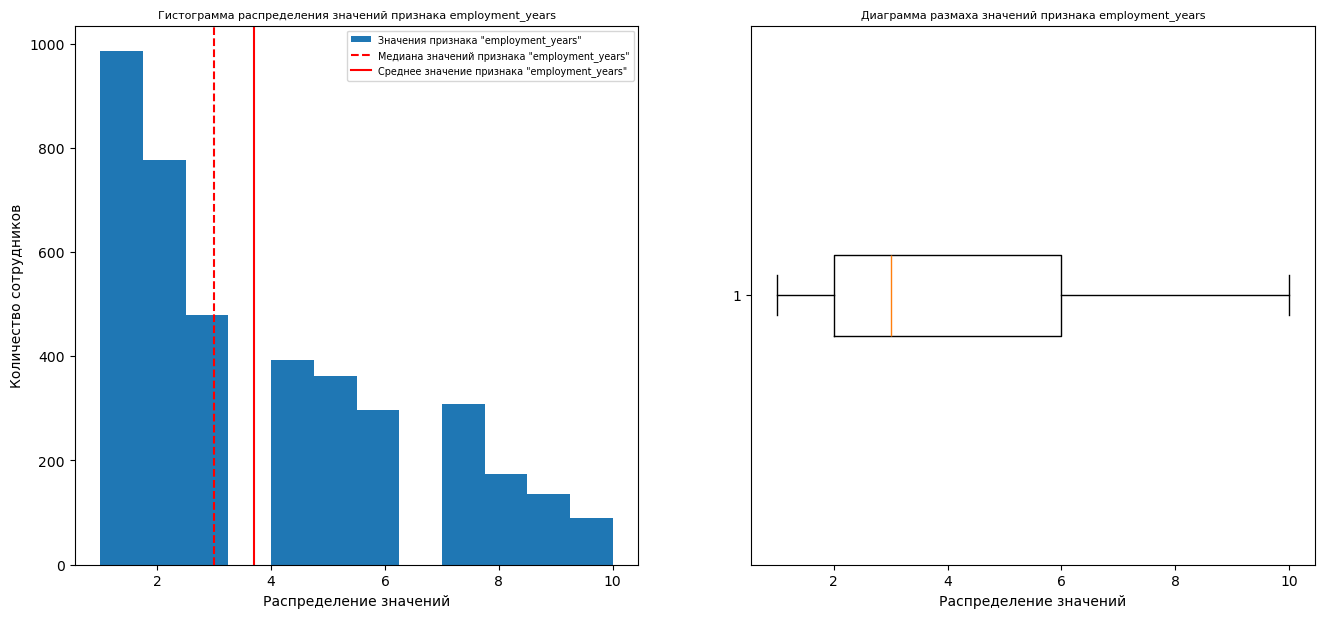

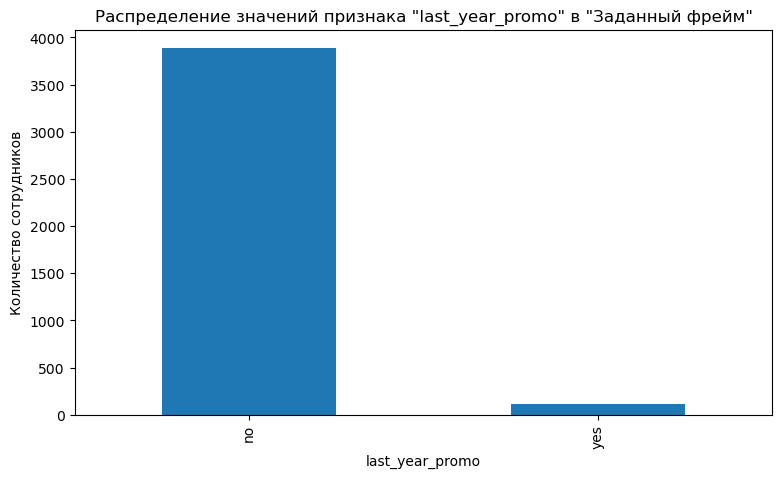

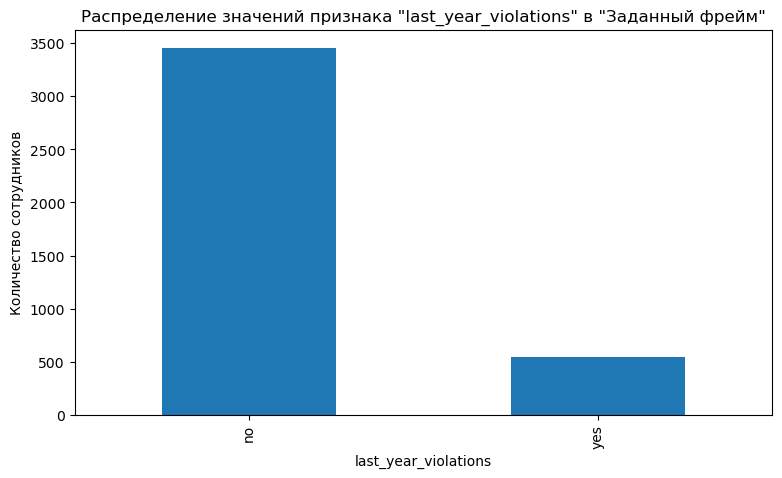

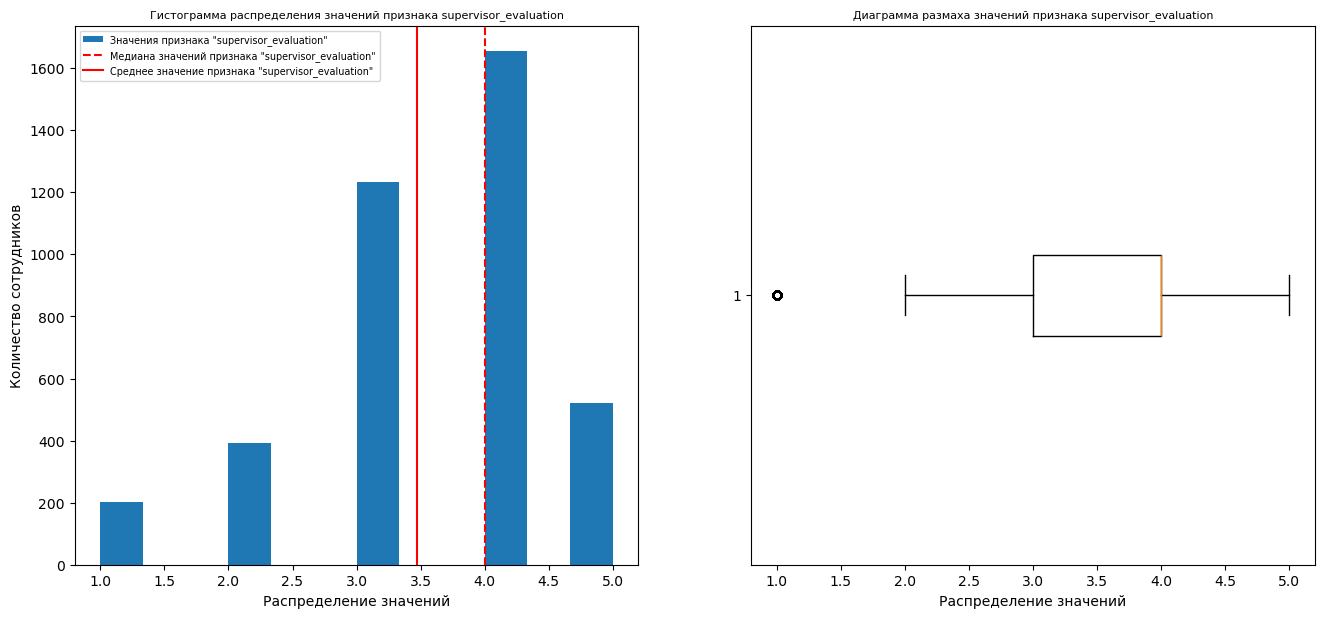

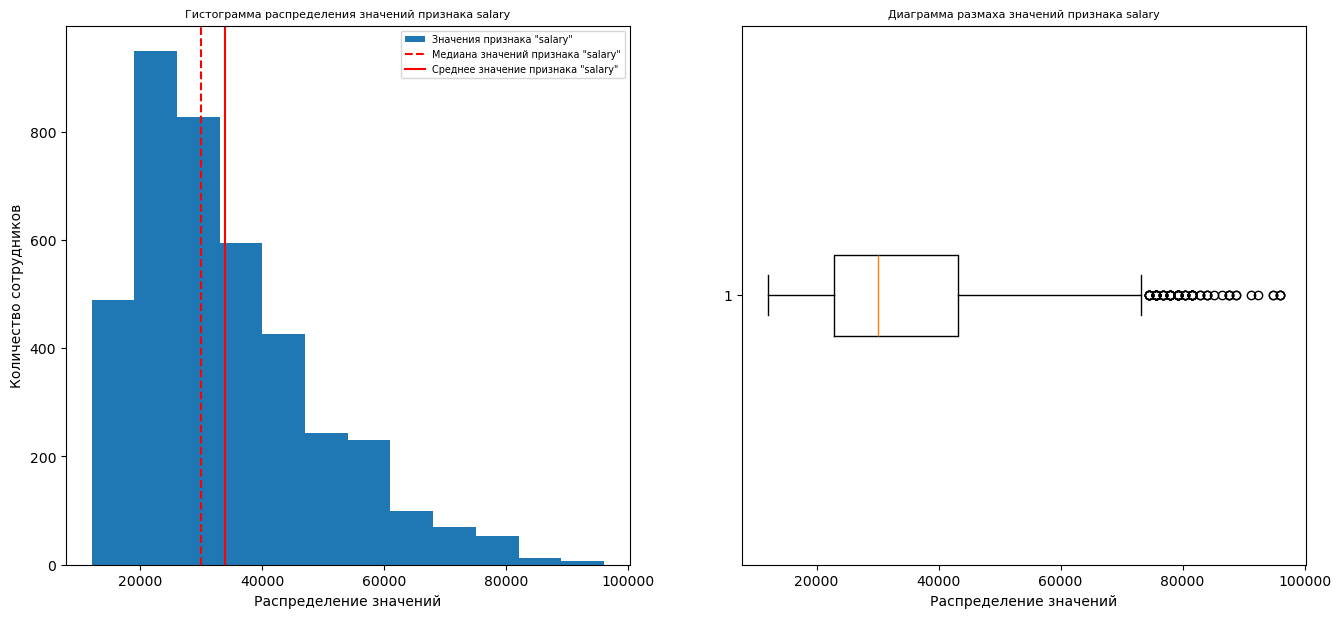

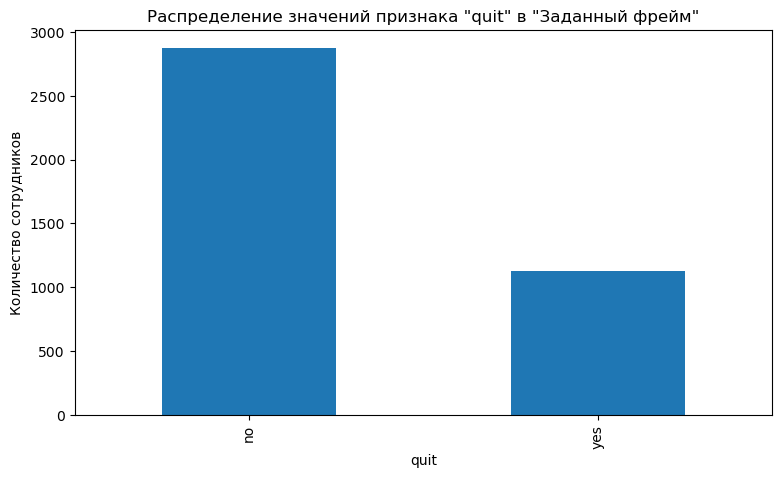

In [56]:
make_plot(quit_train)

Графики идентичны полученным в первом задании, [выводы аналогичны](#analysis_plots_first). Удалим выбросы из выборки

In [57]:
quit_train_filtered = quit_train.query('salary < 70000 and supervisor_evaluation > 1')

Выбросы удалены. Проверим распределение данных **только** уволившихся сотрудников

#### Портрет уволившегося сотрудника

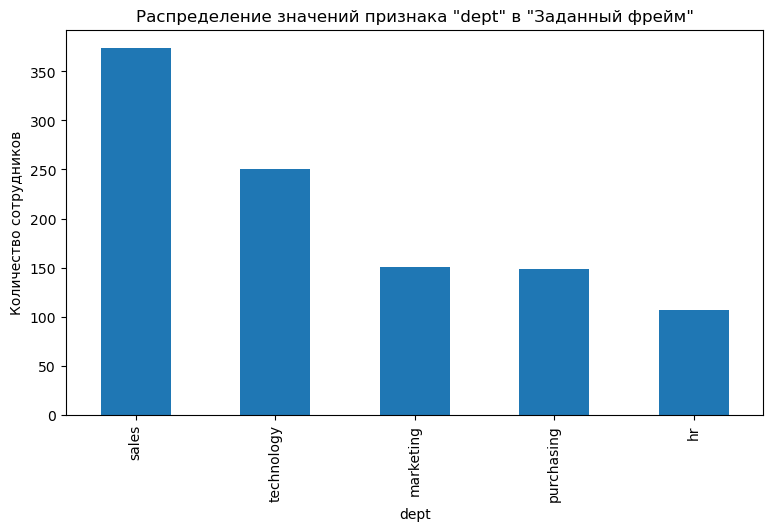

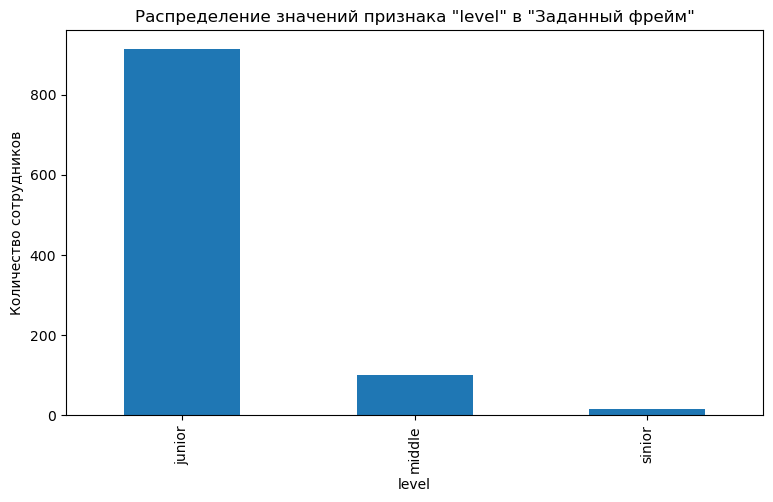

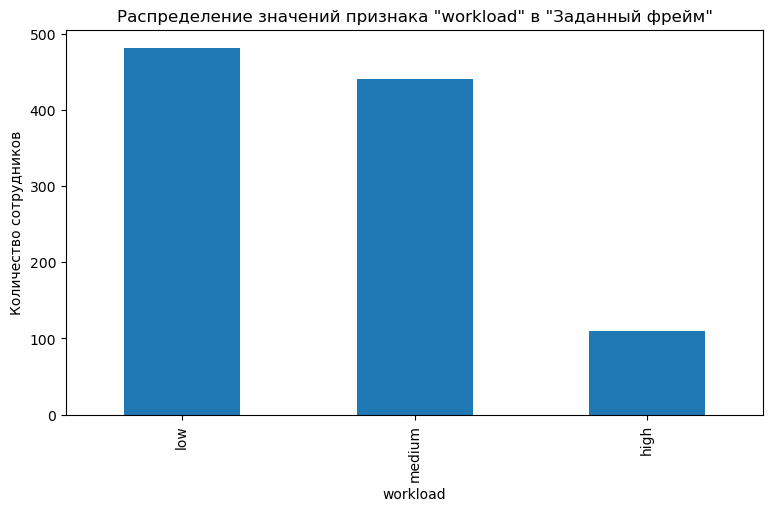

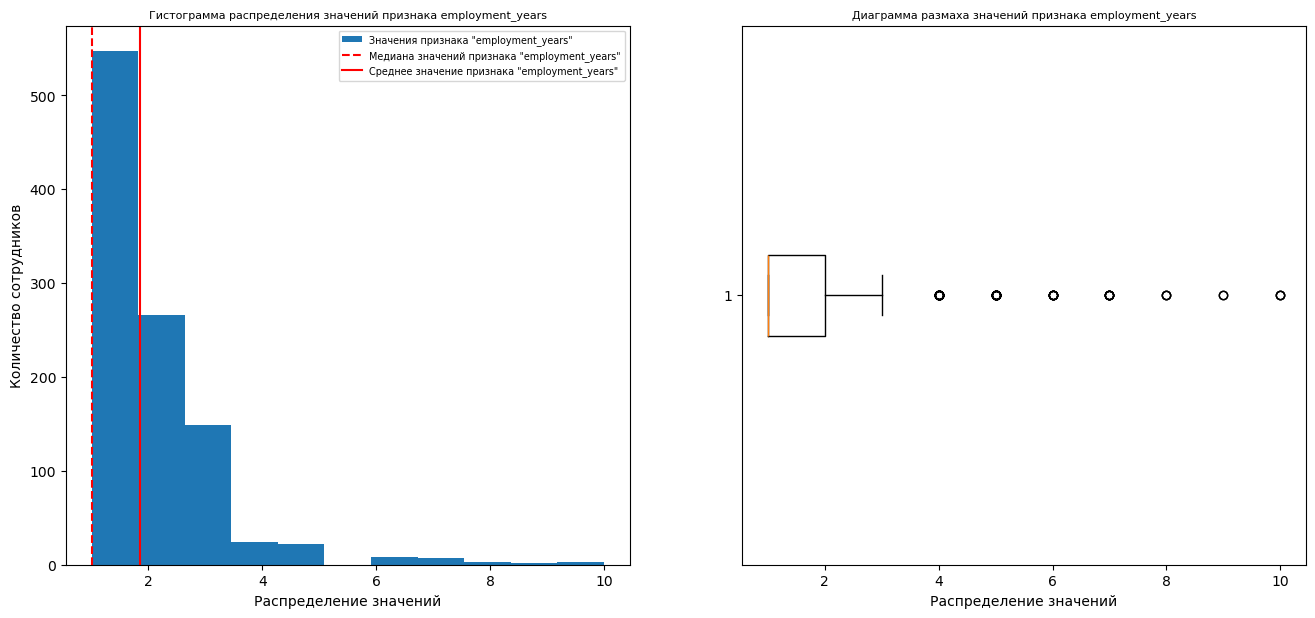

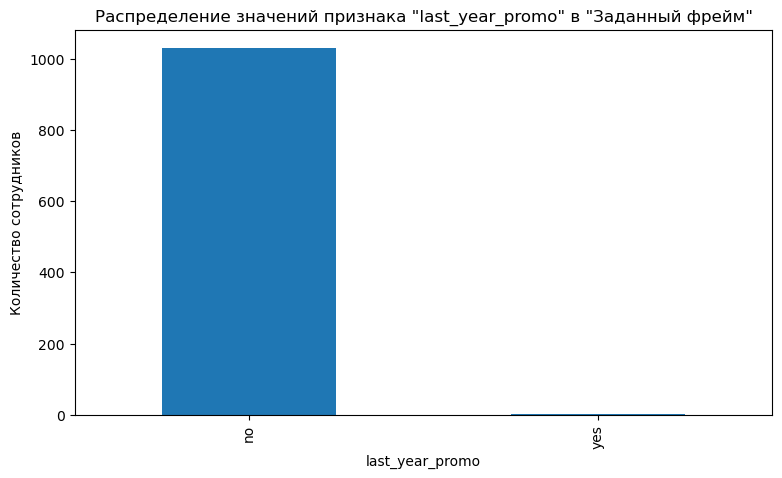

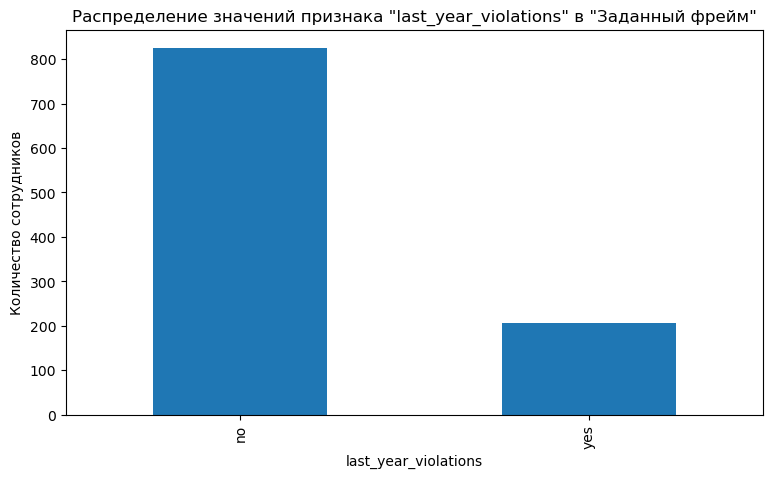

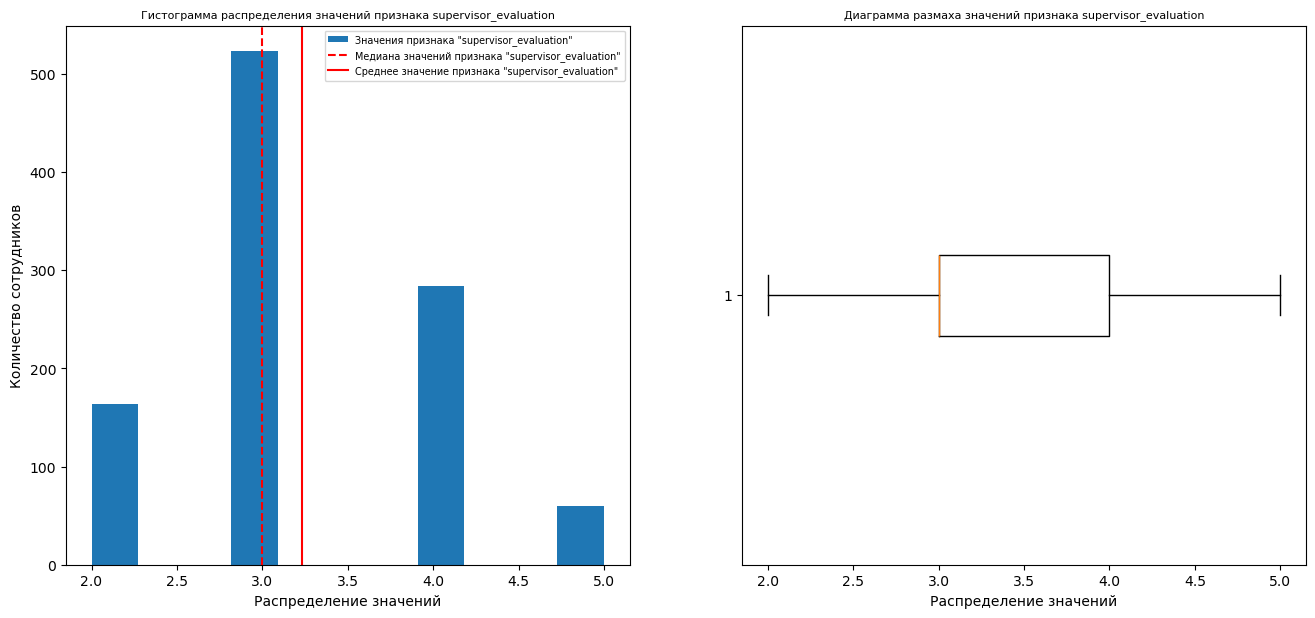

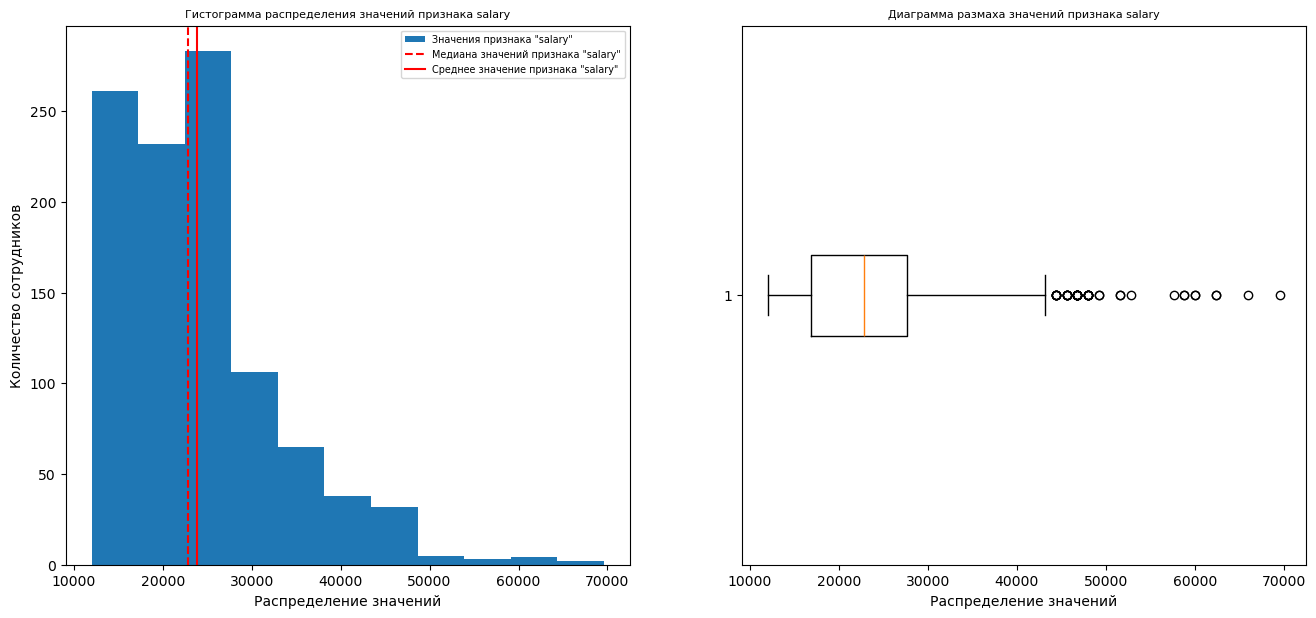

In [58]:
make_plot(
    quit_train_filtered.query('quit == "yes"')
                       .drop('quit', axis=1)
)

Таким образом, среднестатистический уволившийся сотрудник компании:
- Работает в департаменте *sales* на младшей позиции
- У него не было высокой загрузки
- Работал не более двух лет в компании
- Не имел повышения в прошлом году
- Не нарушал трудовой договор в прошлом году
- Руководитель оценил работу сотрудника на 3/5
- Зарабатывал ~ 24 000

Добавим распределение долей уволившихся сотрудников в разрезе департаментов компании:

dept
technology    0.296209
marketing     0.281192
purchasing    0.278505
sales         0.276627
hr            0.248837
Name: dept, dtype: float64

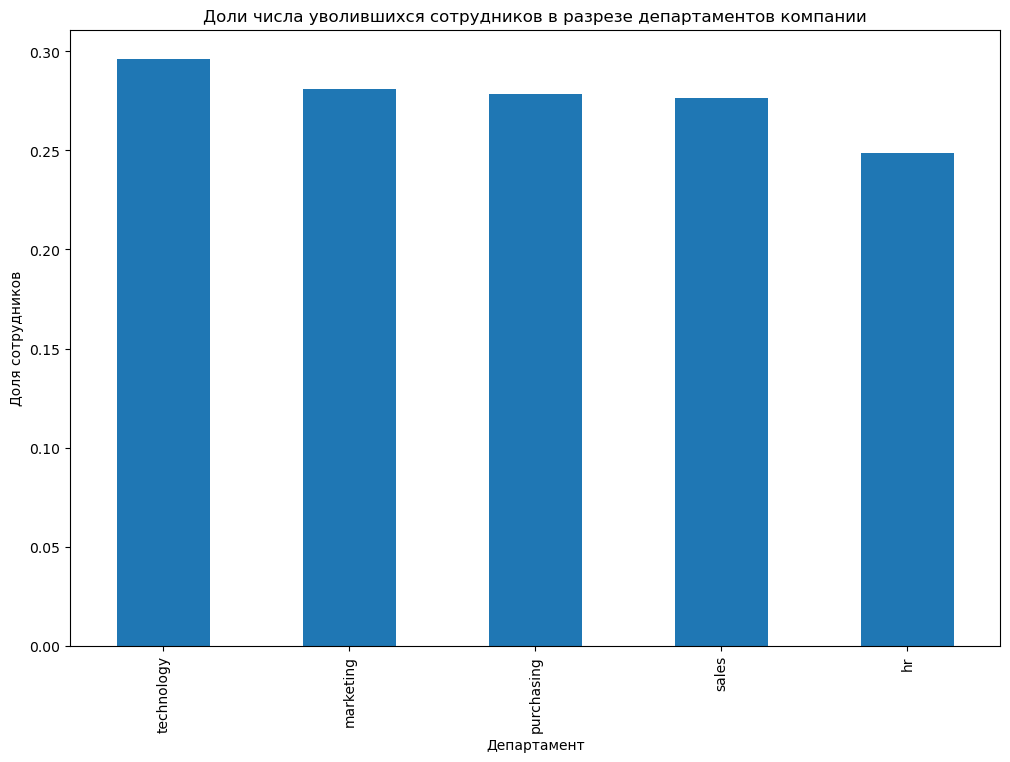

In [59]:
quit_prec = (
    # Число уволившихся сотрудников в разрезе отделов
    quit_train_filtered.query('quit == "yes"').groupby('dept')['dept'].count() /
    # Общее число сотрудников в разрезе отделов
    quit_train_filtered.groupby('dept')['dept'].count()
).sort_values(ascending=False)

# Вывод долей
display(quit_prec)

# Визуализация долей
quit_prec.plot(kind='bar',
               title='Доли числа уволившихся сотрудников в разрезе департаментов компании',
               ylabel='Доля сотрудников',
               xlabel='Департамент',
               figsize=(12, 8))

plt.show()

По приведенному выше анализу можно заключить, что в компании наблюдается высокий уровень текучки сотрудников (нормой считается [3-7% в год](https://skillbox.ru/media/management/chto-takoe-tekuchest-kadrov-po-kakoy-formule-eye-schitayut-i-kak-snizhayut/), в данной же компании уровень текучки составляет более 25%).

Также по графику видно, что наиболее "текучим" департаментом является департамент *technology*, доля уволившихся сотрудников которого составляет почти 30%

#### Анализ корреляции целевого признака и уровня удовлетворенности работой (`job_satisfaction_rate`)

Проверим корреляцию целевого признака и уровня удовлетворенности работой. Проанализируем корреляцию на целевых признаках двух заданий. Построим гистограммы распределения признака `job_satisfaction_rate` в разрезе целевого признака

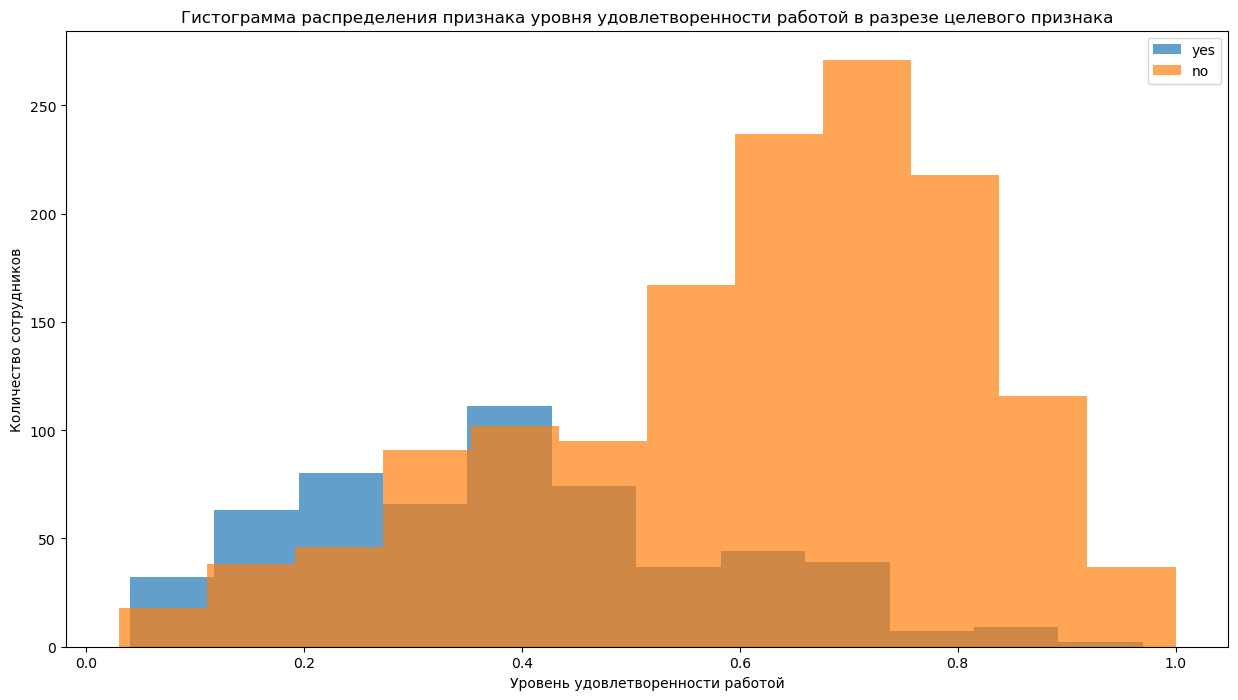

In [60]:
# Объединение признаков
df = quit_target.join(satisfaction_target)

# Задаем количество корзин
bins = int(log(df.size, 2)) + 1

# Перебираем циклом уникальные значения целевого признака
for type in df['quit'].unique():
    (   # Получаем необходимых сотрудников
        df.query('quit == @type')
           # Выбираем необходимый признак
           ['job_satisfaction_rate']
           # Строим график
            .plot(kind='hist',
                  bins=bins,
                  alpha = 0.7,
                  label=type,
                  figsize=(15, 8))
    )

# Кастомизируем график
plt.title('Гистограмма распределения признака уровня удовлетворенности работой в разрезе целевого признака')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Количество сотрудников')
plt.legend()

# Выводим график
plt.show()

**Вывод:** корреляция между признаками наблюдается, однако невысокая. По графику видно, что более высокий уровень удовлетворенности работой снижает вероятность увольнения

#### Промежуточные выводы шага

Распределение данных совпадает с аналогичной выборкой первого задания.

Среднестатистический уволившийся сотрудник:
- Работает в департаменте *sales* на младшей позиции
- У него не было высокой загрузки
- Работал не более двух лет в компании
- Не имел повышения в прошлом году
- Не нарушал трудовой договор в прошлом году
- Руководитель оценил работу сотрудника на 3/5
- Зарабатывал ~ 24 000

Также была выявлена взаимосвязь между целевым признаком и уровнем удовлетворенностью работой. Необходимо провести корреляционный анализ данных после добавления данного признака

### Добавление нового признака

С помощью модели, полученной по итогу первого задания, дополним тренировочную и тестовую выборки. После чего проведем корреляционный анализ.

#### Добавление признака в тренировочную выборку

Добавим доп признак к тренировочным данным по прогнозным значениям модели из первой задачи:

In [61]:
# Добавляем в фрейм доп признак по предсказанным значениям
quit_train_filtered['job_satisfaction_rate'] = best_pipeline.predict(quit_train_filtered[quit_test.columns])
# Проверка
if ~quit_train_filtered['job_satisfaction_rate'].isna().sum():
    print('Доп признак был успешно добавлен.')
    display(quit_train_filtered['job_satisfaction_rate'].sample(5))
else:
    print('Модель сработала некорректно. Проверь первое задание')

Доп признак был успешно добавлен.


C:\Users\Александр\AppData\Local\Temp\ipykernel_7848\919170248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quit_train_filtered['job_satisfaction_rate'] = best_pipeline.predict(quit_train_filtered[quit_test.columns])


id
499788    0.937500
142460    0.173182
816619    0.817000
365994    0.333333
472435    0.841538
Name: job_satisfaction_rate, dtype: float64

#### Добавление признака в тестовую выборку

Тестовые данные объединим с целевым признаком из первого задания:

In [62]:
quit_test = quit_test.join(satisfaction_target)
# Проверка
if ~quit_test['job_satisfaction_rate'].isna().sum():
    print('Доп признак был успешно добавлен.')
    display(quit_test['job_satisfaction_rate'].sample(5))
else:
    print('Модель сработала некорректно. Проверь первое задание')

Доп признак был успешно добавлен.


id
555658    0.71
581016    0.63
267179    0.54
587378    0.74
585043    0.21
Name: job_satisfaction_rate, dtype: float64

Объединим тестовые данные и целевой признак в общий фрейм 

In [63]:
quit_test_full = quit_test.join(quit_target)
# Проверка
if ~quit_test_full['quit'].isna().sum():
    print('Объединение было успешно')
    display(quit_test_full['quit'].sample(5))
else:
    print('Объединение некорректное. Проверь еще раз!')

Объединение было успешно


id
633632    no
620147    no
174065    no
591199    no
488424    no
Name: quit, dtype: object

#### Корреляционный анализ

Проведем корреляционный анализ после добавления нового признака

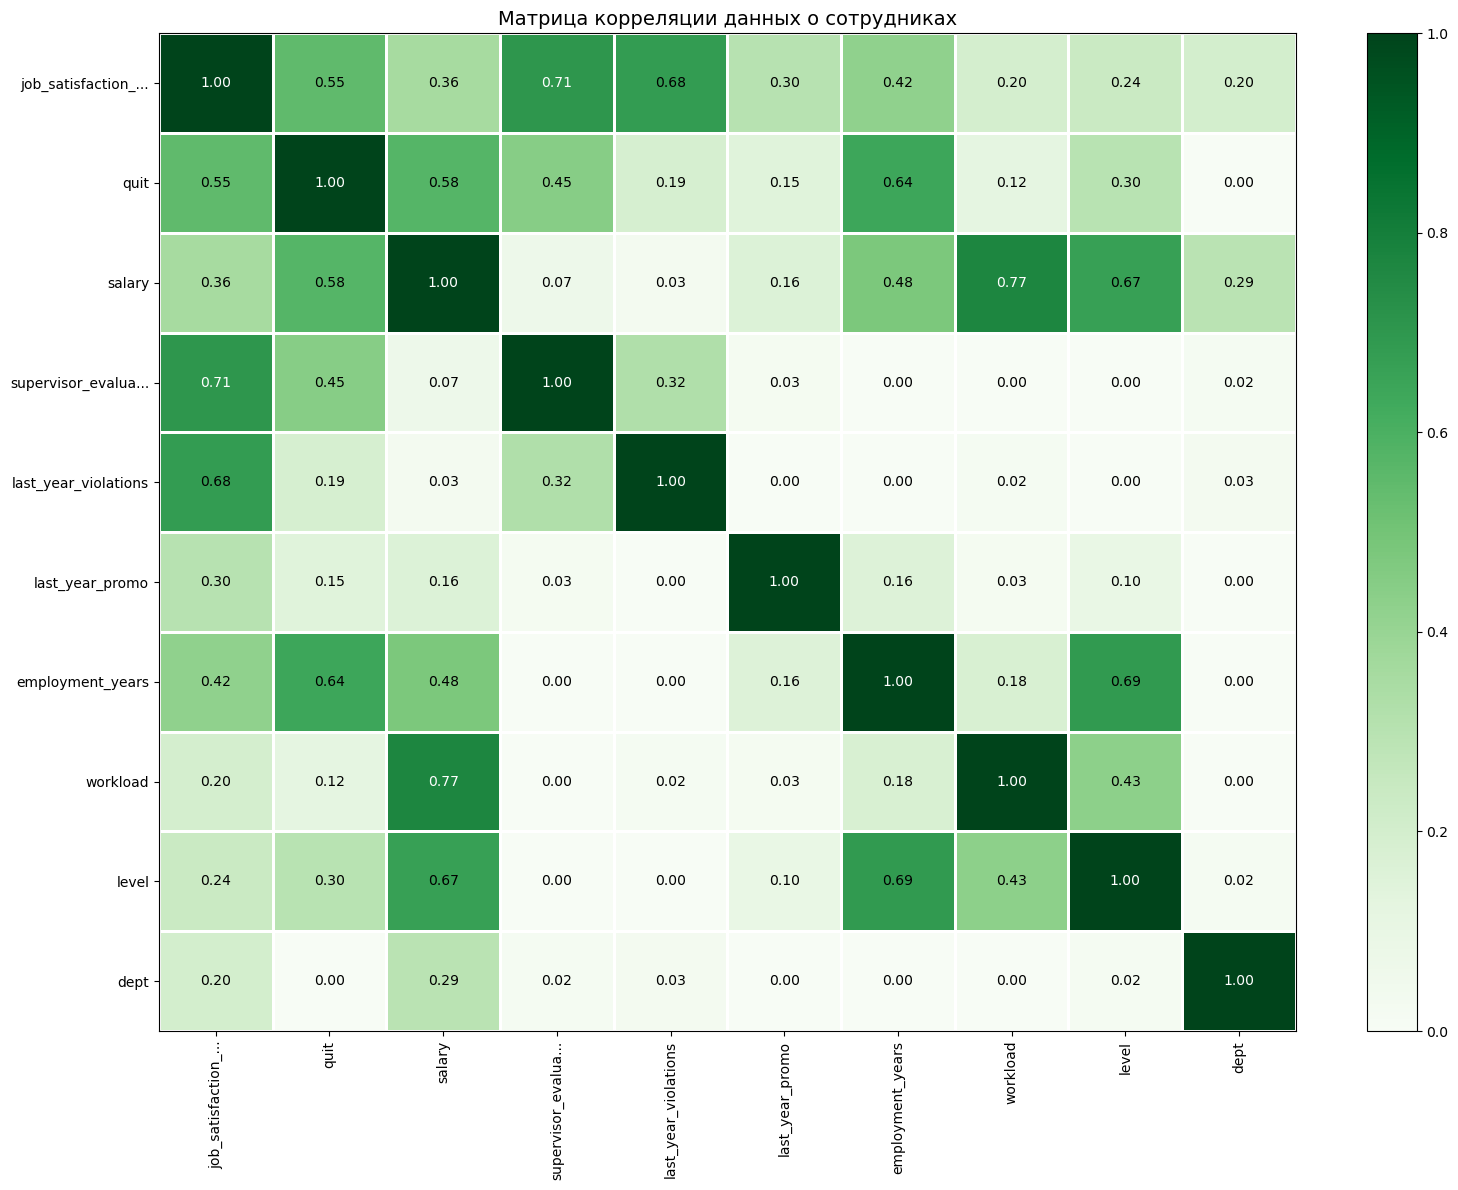

In [64]:
# Создаем матрицу корреляции
phik_overview = phik_matrix(quit_train_filtered,
                            interval_cols=['salary', 'job_satisfaction_rate'])

# Визуализируем матрицу
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Greens',
    title='Матрица корреляции данных о сотрудниках',
    figsize=(16, 12)
) 

Целевой признак больше всего коррелирует со следующими признаками:
- Длительность работы в компании
- Ежемесячная зарплата сотрудника
- Уровень удовлетворенности работой

Также наблюдается мультиколлиниарность, [помимо выявленной в первой задаче](#multi-corr):
- Уровень удовлетворенностью работой и Оценка работы руководителем
- Уровень удовлетворенностью работой и нарушения трудового договора в прошлом году

#### Промежуточный вывод шага

Был добавлен доп признак "Уровень удовлетворенности работой", а также проведен корреляционный анализ входных признаков

### Подготовка данных

Предобработка данных в данном задании будет идентична предобработке первого задания. Отличием будет то, что для стандартизации будет использоваться доп признак, добавленный на прошлом шаге

In [65]:
stand_cols.append('job_satisfaction_rate')

#### Кодирование целевого признака

Закодируем целевой признак в тренировочной и тестовой выборок

In [66]:
le = LabelEncoder()
quit_train_filtered['quit'] = le.fit_transform(quit_train_filtered['quit'])
print('Значения кодировщика: ', dict(zip(le.classes_, le.transform(le.classes_))))
quit_test_full['quit'] = le.transform(quit_test_full['quit'])

Значения кодировщика:  {'no': 0, 'yes': 1}


C:\Users\Александр\AppData\Local\Temp\ipykernel_7848\497518438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quit_train_filtered['quit'] = le.fit_transform(quit_train_filtered['quit'])


### Обучение модели

Будем использовать наработки первого задания. Создадим полный пайплайн, который прогоним через кроссвалидации для поиска лучшей модели. В качестве метрики будем использовать `ROC-AUC`

#### Итоговый пайплайн

In [67]:
pipe_final_second = Pipeline(
    [
        (   # Предобработка данных
            'preprocessor',
            data_preprocessor
        ),
        (   # Отбор признаков
            'skb',
            SelectKBest(mutual_info_classif, k=2)
        ),
        (   # Алгоритм прогнозирования
            'model',
            LogisticRegression()
        )
    ]
)

#### Поиск лучшей модели

Введем параметры для поиска лучшей модели. Параметры перебора алгоритмов стандартизации изменим. Параметры отбора лучшего набора признаков изменим:

In [68]:
data_preprocessor.fit_transform(quit_train_filtered.drop('quit', axis=1))
skb__k = range(2, len(data_preprocessor.get_feature_names_out()))

Введем параметра для поиска лучшей модели

In [69]:
model_params = [
    {
        'model': [LogisticRegression()],
        'model__penalty': ['l1', 'l2'],
        'model__C': np.linspace(0.1, 1, 10),
        'skb__k': skb__k,
        'skb__score_func': [f_classif, mutual_info_classif],
        'preprocessor__quan': preprocessor__quan        
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(3, 11),
        'skb__k': skb__k,
        'skb__score_func': [f_classif, mutual_info_classif],
        'preprocessor__quan': preprocessor__quan 
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 11),
        'model__min_samples_split': range(2, 11),
        'model__min_samples_leaf': range(1, 11),
        'skb__k': skb__k,
        'skb__score_func': [f_classif, mutual_info_classif],
        'preprocessor__quan': preprocessor__quan
    }
]

Применим `RandomizedSearchCV` для поиска лучшей модели. Метрикой будет `ROC-AUC`

In [70]:
search = RandomizedSearchCV(
    pipe_final_second, 
    param_distributions=model_params, 
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
).fit(
    quit_train_filtered.drop('quit', axis=1),
    quit_train_filtered['quit']
)

Выведем лучшую модель и ее метрику

In [71]:
print('Метрика ROC-AUC для лучшей модели:\n', search.best_score_)
print('\nЛучшая модель и её параметры:\n', search.best_estimator_) 

Метрика ROC-AUC для лучшей модели:
 0.9248180662973408

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                        

In [72]:
best_pipeline = search.best_estimator_
print('ROC-AUC метрика на тестовой выборке составляет:', 
      roc_auc_score(quit_test_full['quit'],
                    best_pipeline.predict(quit_test_full.drop('quit', axis=1)))
     )

ROC-AUC метрика на тестовой выборке составляет: 0.9129995653805884


c:\Users\Public\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Интерпретация модели

Проведем интерпретацию модели с помощью `SHAP`. <span id='features'>Выведем признаки, которая модель приняла в качестве важных

In [73]:
# Выбираем лучшую модель
best_pipeline = search.best_estimator_

# Получаем наименования признаков после их преобразовния
coltrans = best_pipeline['preprocessor'].get_feature_names_out()

# Получаем наименования признаков после их отбора
skb_features = best_pipeline['skb'].get_feature_names_out(coltrans)
print(skb_features)

['ohe__dept_technology' 'ohe__last_year_violations_yes' 'ord__workload'
 'ord__level' 'quan__salary' 'quan__employment_years'
 'quan__job_satisfaction_rate' 'remainder__supervisor_evaluation']


Выведем график для анализа важности признаков

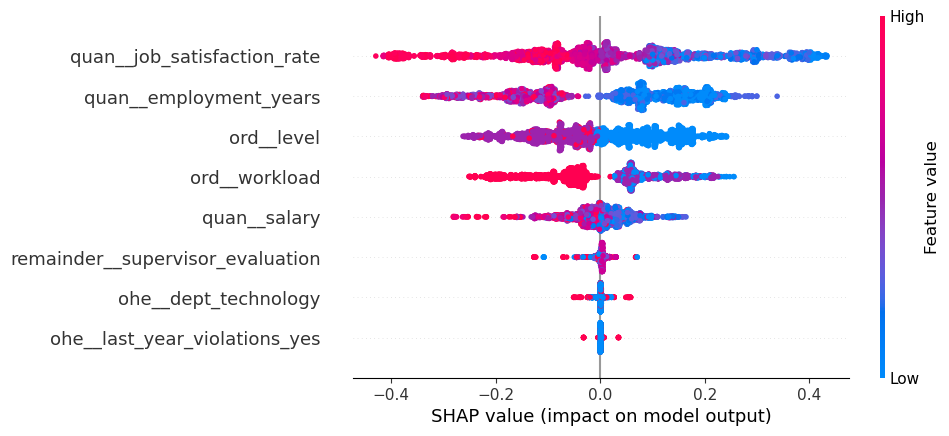

In [74]:
X_train_ = pd.DataFrame(
    best_pipeline['preprocessor'].transform(quit_train_filtered.drop('quit', axis=1)),
    columns=coltrans
)[skb_features]

explainer = shap.TreeExplainer(best_pipeline['model'], X_train_)
shap_values = explainer(X_train_)

shap.plots.beeswarm(shap_values[:, :, 1])

Выведем закодированные в OrdinalEncoder значения

In [75]:
best_pipeline['preprocessor'].transformers_[1][1][1].categories_

[array(['high', 'low', 'medium'], dtype=object),
 array(['junior', 'middle', 'sinior'], dtype=object)]

По графику выше видно, что на вероятность увольнения сотрудника влияют в большей мере следующие признаки:
- **Низкая удовлетворенность работой** - неудовлетворенный сотрудник будет скорее искать более хорошую работу
- **Малое количество проработанных в компании лет** - человек скорее склонен уйти, если он работал меньше в компании
- **Низкая позиция в компании** - неудовлетворенность позицией или окончание "обучения" на работе (или пробного периода)
- **Высокая/низкая загруженность** - слишком сложная или слишком простая работа не удовлетворяет сотрудников
- **Низкая зарплата** - сотрудник ищет работу, где будет получать больше

### Вывод второй задачи

По резултатам работы алгоритма отбора лучшего пайплайна лучшей моделью стал алгоритм `DecisionTreeClassifier` с максимальной глубиной 10, минимальным числом листов - 8 и объектов для деления 3. При этом использовался алгоритм стандартизации `StandardScaler()`. Алгоритм отбора признаков выбрал [8 наиболее важных признаков](#features) для данной модели.

На тестовой выборке модель показала качество 0.913 по метрике `ROC-AUC`, что удовлетворяет требованиям задачи.

На вероятность увольнения сотрудника влияют в большей мере следующие признаки:
- Низкая удовлетворенность работой
- Малое количество проработанных в компании лет
- Низкая позиция в компании
- Высокая/низкая загруженность
- Низкая зарплата

## Общий вывод по проекту

***Описание проекта***: HR-аналитикам компании "Работа с заботой" необходима помощь в оценке удовлетворенности компании с целью минимизации оттока сотрудников и снижения рисков для компании. Результатом помощи ожидается модель МО, которая позволит добиться необходимых HR аналитикам целей.

***Выполненные шаги.*** Было разработано две модели МО. Первая модель была создана на основе алгоритма регрессии с целью прогнозирования уровня удолветворенности работой сотрудников компании. Вторая модель основывалась на алгоритме классификации для прогнозирования вероятности увольнения сотрудника.

В обеих задачах были предприняты следующие шаги:
- Загрузка и первичный анализ данных
- Предобработка данных, в ходе которой во всех фреймах признак **id** был принят в качестве индекса
- Исследовательский анализ данных, по результату которого в обеих тренировочных выборках были обнаружены и исправлены выбросы
- Подготовка данных к МО с помощью пайплайна
- Создание полного пайплайна модели МО
- Применение алгоритма отбора лучшей модели МО (RandomizedSearchCV) и анализ лучшего результата

Модели обеих задач показали допустимое качество на тестовых данных.

***Результаты проекта:***<br>
Итак по результатам кросс валидации лучшей моделью была выявлена модель `DecisionTreeRegressor` c максимальной глубиной 14, минимальным числом листов - 7 и числом объектов для деления - 7. Масштабирующим алгоритмом при этом выбран `MinMaxScaler()`.

На тестовой выборке модель показала значение 14.681 по метрике `SMAPE`, что удовлетворяет требованию задачи.

На уровень удовлетворенности влияет больше всего оценка работы руководителем (хорошо видно на графике, что высокая оценка руководителя повышает удовлетворенность работой и наоборот). Также на данный параметр влияют такие признаки, как:
- **Продолжительность работы в компании** - "старые" сотрудники более довольны работой
- **Низшая позиция** - сотрудники на низких позициях имеют меньше ответственности, меньше погружены в "кухню" компании, а значит получают меньше стресса
- **Более высокая зарплата** - высокая зарплата позволяет больше тратить на "высшие" потребности, что позволяет сотруднику меньше стрессовать на работе
- **Отсутствие нарушений трудового договора в прошлом году** - обратная связь с удовлетворенностью работой (чем выше сотрудник удовлетворен работой, тем меньше вероятность, что он нарушит договор)
- **Работа не в департаменте technology** - возможно, самый застресованный департамент компании
- **Повышение в прошлом году** - повышение связано зачастую с повышением заработной платы, а ее влияние описано раннее

По резултатам работы алгоритма отбора лучшего пайплайна лучшей моделью стал алгоритм `DecisionTreeClassifier` с максимальной глубиной 10, минимальным числом листов - 8 и объектов для деления 3. При этом использовался алгоритм стандартизации `StandardScaler()`. Алгоритм отбора признаков выбрал 8 наиболее важных признаков для данной модели.

На тестовой выборке модель показала качество 0.913 по метрике `ROC-AUC`, что удовлетворяет требованиям задачи.

На вероятность увольнения сотрудника влияют в большей мере следующие признаки:
- **Низкая удовлетворенность работой** - неудовлетворенный сотрудник будет скорее искать более хорошую работу
- **Малое количество проработанных в компании лет** - человек скорее склонен уйти, если он работал меньше в компании
- **Низкая позиция в компании** - неудовлетворенность позицией или окончание "обучения" на работе (или пробного периода)
- **Высокая/низкая загруженность** - слишком сложная или слишком простая работа не удовлетворяет сотрудников
- **Низкая зарплата** - сотрудник ищет работу, где будет получать больше

***Рекомендации бизнесу:*** 
- Наибольшая текучка, а также меньшая удовлетворенность работой наблюдается среди отдела technology, следует обратить внимание на уровень удолветворенности сотрудников данного департамента
- Вероятность увольнения выше у сотрудников позиции juniour - hr отделу стоит лучше отбирать новых малоопытных сотрудников для уменьшения текучки кадров (это также подтверждается данными, что сотрудник скорее уволится, если он проработал немного в компании)
- Стоит проанализировать конкурентноспособность заработной платы компании, так как это один из ключевых признаков, влияющих на удовлетворенность работой и вероятность увольнения сотрудника
- Также стоит проверить и нормализовать загруженность сотрудников, так как недостаточная или завышенная загруженность повышает вероятность увольнения сотрудников